<a href="https://colab.research.google.com/github/litbe/Python/blob/master/SQLInjectionDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sample. 
https://github.com/oreilly-japan/ml-security-jp/blob/master/ch07/Chapter7.ipynb  


https://github.com/Morzeux/HttpParamsDataset

In [1]:
import pandas as pd
df = pd.read_csv('./payload_train.csv')

In [2]:
print(df)

                                                 payload  ...  label
0                                         c/ caridad s/n  ...   norm
1                                           campello, el  ...   norm
2                                       1442431887503330  ...   norm
3                                                  nue37  ...   norm
4                                         tufts3@joll.rs  ...   norm
...                                                  ...  ...    ...
20707  <!--#exec cmd="/bin/echo '<script src'"--><!--...  ...   anom
20708  <head><meta http-equiv="content-type" content=...  ...   anom
20709  <script a=">" id=xss src="http://ha.ckers.org/...  ...   anom
20710  <script "a='>'" id=xss src="http://ha.ckers.or...  ...   anom
20711  <script a=`>` id=xss src="http://ha.ckers.org/...  ...   anom

[20712 rows x 4 columns]


In [3]:
import numpy as np
import pandas as pd

#HTTP query entropy
def H_entropy(x):
  prob = [ float(x.count(c)) / len(x) for c in dict.fromkeys(list(x))]
  H = - sum([p * np.log2(p) for p in prob])
  return H

In [4]:
#normal label
df_norm = df[df.attack_type == 'norm']

#list
norm_entropies = []

# payload
for i in df_norm['payload']:
  norm_entropies.append(H_entropy(i))

In [5]:
#entropy
sum(norm_entropies) / len(norm_entropies)

2.7658075808985836

In [6]:
#sqli label
df_sqli = df[df.attack_type == 'sqli']

#list
sqli_entropies = []

# payload
for i in df_sqli['payload']:
  sqli_entropies.append(H_entropy(i))

In [7]:
#entropy
sum(sqli_entropies) / len(sqli_entropies)

4.289379819336267

<function matplotlib.pyplot.show>

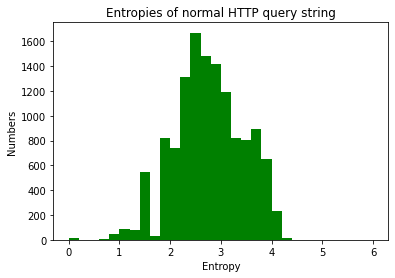

In [8]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()

ax.set_title('Entropies of normal HTTP query string')
ax.set_xlabel('Entropy')
ax.set_ylabel('Numbers')

plt.hist(norm_entropies, bins=30, range=(0,6), color='green')
plt.show

<function matplotlib.pyplot.show>

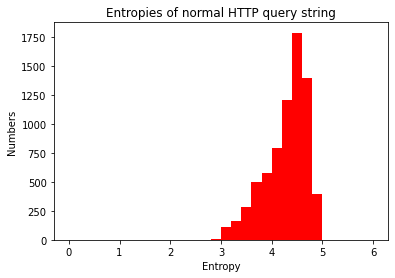

In [9]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()

ax.set_title('Entropies of normal HTTP query string')
ax.set_xlabel('Entropy')
ax.set_ylabel('Numbers')

plt.hist(sqli_entropies, bins=30, range=(0,6), color='red')
plt.show

In [10]:
df_sqli = df[df.attack_type == 'sqli']
df_sqli

payload  ...  label
291    1' where 6406=6406;select count(*) from rdb$fi...  ...   anom
292    1) and 8514=(select count(*) from domain.domai...  ...   anom
293                      1) where 7956=7956 or sleep(5)#  ...   anom
294                               -7387'))) order by 1--  ...   anom
295                1))) union all select null,null,null#  ...   anom
...                                                  ...  ...    ...
20360          1%")) and elt(4249=4249,7259) and (("%"="  ...   anom
20361  -7773' or 5903=('qqpjq'||(select case 5903 whe...  ...   anom
20362                                    1" order by 1--  ...   anom
20363  1' procedure analyse(extractvalue(5840,concat(...  ...   anom
20364  -7511)) as xqzf where 9939=9939 union all sele...  ...   anom

[7235 rows x 4 columns]

In [11]:
print('{:.2%}'.format(
    df_sqli['payload'].str.contains('\)').sum() \
    / len(df_sqli['payload'])
    )
)

90.91%


In [12]:
df_norm = df[df.attack_type == 'norm']

print('{:.2%}'.format(
    df_norm['payload'].str.contains('\)').sum() \
    / len(df_norm['payload'])
    )
)

0.01%


In [13]:
# Extend the dataset to add add new features
def func_preprocessing(df):
  train_rows = ((df.attack_type == 'norm') | (df.attack_type == 'sqli'))
  df = df[train_rows]

  entropies = []
  closing_parenthesis = []

  # Extract HTTP query string from pyaload string and let it be processed
  for i in df['payload']:
    # Calculation of entropy
    entropies.append(H_entropy(i))
    # ')'detection
    if i.count(')'):
      closing_parenthesis.append(1)
    else :
      closing_parenthesis.append(0)
  # Add dataset
  df = df.assign(entropy=entropies)
  df = df.assign(closing_parenthesis=closing_parenthesis)

  rep = df.label.replace({"norm":0, "anom":1})
  df = df.assign(label=rep)

  return df


In [14]:
df = func_preprocessing(df)
df

payload  ...  closing_parenthesis
0                                         c/ caridad s/n  ...                    0
1                                           campello, el  ...                    0
2                                       1442431887503330  ...                    0
3                                                  nue37  ...                    0
4                                         tufts3@joll.rs  ...                    0
...                                                  ...  ...                  ...
20360          1%")) and elt(4249=4249,7259) and (("%"="  ...                    1
20361  -7773' or 5903=('qqpjq'||(select case 5903 whe...  ...                    1
20362                                    1" order by 1--  ...                    0
20363  1' procedure analyse(extractvalue(5840,concat(...  ...                    1
20364  -7511)) as xqzf where 9939=9939 union all sele...  ...                    1

[20105 rows x 6 columns]

SQL injection Detector

In [15]:
test_data = pd.read_csv('./payload_test.csv')
test_data = func_preprocessing(test_data)

# Extract of features
df_x = df[['length', 'entropy', 'closing_parenthesis']]
test_x = test_data[['length', 'entropy', 'closing_parenthesis']]

# Extract labels
df_y = df[['label']]
test_y = test_data[['label']]

X_all = pd.concat([df_x, test_x])
y_all = pd.concat([df_y, test_y])

print(X_all)
print(y_all)

       length   entropy  closing_parenthesis
0          14  3.093069                    0
1          12  3.022055                    0
2          16  2.827820                    0
3           5  2.321928                    0
4          14  3.378783                    0
...       ...       ...                  ...
10176     113  4.422041                    1
10177     113  4.514233                    1
10178     136  4.630369                    1
10179     111  4.539371                    1
10180      53  4.130354                    1

[30156 rows x 3 columns]
       label
0          0
1          0
2          0
3          0
4          0
...      ...
10176      1
10177      1
10178      1
10179      1
10180      1

[30156 rows x 1 columns]


In [16]:
!pip install optuna

     |████████████████████████████████| 308 kB 5.3 MB/s 
     |████████████████████████████████| 80 kB 8.3 MB/s 
     |████████████████████████████████| 210 kB 54.7 MB/s 
     |████████████████████████████████| 75 kB 4.1 MB/s 
     |████████████████████████████████| 49 kB 5.2 MB/s 
     |████████████████████████████████| 112 kB 44.5 MB/s 
     |████████████████████████████████| 149 kB 58.7 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=7e42848acda6481c6232f8d08900d9745e7c703556b37b89458f1c560b5aa2a1
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split
import numpy as np
import optuna
from sklearn.model_selection import cross_validate

# データセットを訓練用とテスト用に分割
X_train, X_test, y_train, y_test = \
train_test_split(X_all, y_all, test_size=0.2, shuffle=True, random_state=101)

class Objective_DTC:
    def __init__(self, X, y):
        # 変数 X,y の初期化
        self.X = X
        self.y = y

    def __call__(self, trial):
        # チューニング対象のハイパーパラメータの設定
        params ={
        'criterion': trial.suggest_categorical(
            'criterion', 
            ['gini', 'entropy']
            ),
        'max_depth': trial.suggest_int(
            'max_depth', 
            1, 64
            )
        }
        model = DecisionTreeClassifier(**params)

        scores = cross_validate(model,
                                X=self.X, y=self.y,
                                scoring='accuracy',
                                n_jobs=-1)
        # 交差検証結果の平均を戻り値に設定
        return scores['test_score'].mean()

objective = Objective_DTC(X_train, y_train)
study = optuna.create_study()
study.optimize(objective, timeout=60)
print('params:', study.best_params)

[I 2022-02-02 23:43:47,911] A new study created in memory with name: no-name-7f525b07-058b-4e46-b5c1-d3aecbe60d0b
[I 2022-02-02 23:43:50,022] Trial 0 finished with value: 0.9813878792565669 and parameters: {'criterion': 'entropy', 'max_depth': 16}. Best is trial 0 with value: 0.9813878792565669.
[I 2022-02-02 23:43:50,249] Trial 1 finished with value: 0.9834605298206721 and parameters: {'criterion': 'gini', 'max_depth': 8}. Best is trial 0 with value: 0.9813878792565669.
[I 2022-02-02 23:43:50,527] Trial 2 finished with value: 0.9800199348679743 and parameters: {'criterion': 'entropy', 'max_depth': 27}. Best is trial 2 with value: 0.9800199348679743.
[I 2022-02-02 23:43:50,809] Trial 3 finished with value: 0.9801442786069652 and parameters: {'criterion': 'gini', 'max_depth': 22}. Best is trial 2 with value: 0.9800199348679743.
[I 2022-02-02 23:43:51,062] Trial 4 finished with value: 0.982507084611485 and parameters: {'criterion': 'entropy', 'max_depth': 14}. Best is trial 2 with value:

params: {'criterion': 'entropy', 'max_depth': 1}


In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# 訓練の実施
model = DecisionTreeClassifier(
    criterion = study.best_params['criterion'],
    max_depth = study.best_params['max_depth']
)
model.fit(X_train, y_train)
pred = model.predict(X_test)

# 正解率と混同行列の出力
print("Accuracy: {:.5f} %".format(100 * accuracy_score(y_test, pred)))
print(confusion_matrix(y_test, pred))

Accuracy: 96.71751 %
[[3847    0]
 [ 198 1987]]


#Ngram

In [19]:
import pandas as pd

df = pd.read_csv('payload_train.csv')
test_data = pd.read_csv('payload_test.csv')

train_rows = ((df.attack_type == 'norm') | (df.attack_type == 'slqi'))
df = df[train_rows]

test_train_rows = ((test_data.attack_type == 'norm') | (test_data.attack_type == 'sqli'))
test_data = test_data[test_train_rows]


In [20]:
df_y = df[['label']]
test_y = test_data[['label']]

df_x = df.iloc[:,:-1]
test_x = test_data.iloc[:,:-1]

X_all = pd.concat([df_x, test_x])
y_all = pd.concat([df_y, test_y])

rep = y_all.label.replace({"norm":0, "anom":1})
y_all = y_all.assign(label=rep)


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

X = X_all['payload']
y = y_all

vec_opts = {
    "ngram_range":(1,1),
    "analyzer": "char",
    "min_df": 0.1
}

v = TfidfVectorizer(**vec_opts)

X = v.fit_transform(X)

features = v.get_feature_names()
np.array(features)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array([' ', '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6',
       '7', '8', '9', '=', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i',
       'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y'],
      dtype='<U1')

In [22]:
df = pd.DataFrame(X.toarray())
df.columns = features
print(df)

                        (         )  ...         v         w         y
0      0.487687  0.000000  0.000000  ...  0.000000  0.000000  0.000000
1      0.242746  0.000000  0.000000  ...  0.000000  0.000000  0.000000
2      0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000
3      0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000
4      0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000
...         ...       ...       ...  ...       ...       ...       ...
22916  0.456583  0.156129  0.195811  ...  0.000000  0.108294  0.054662
22917  0.191063  0.339736  0.319565  ...  0.000000  0.000000  0.000000
22918  0.497850  0.147541  0.185041  ...  0.000000  0.102338  0.000000
22919  0.192826  0.342872  0.322514  ...  0.176391  0.000000  0.000000
22920  0.416998  0.411934  0.387475  ...  0.105960  0.000000  0.000000

[22921 rows x 38 columns]


In [23]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
import optuna.integration.lightgbm as olgb
import optuna

# データセットを訓練用とテスト用に分割
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.2, shuffle=True, random_state=101)

# LightGBM用のデータセットに変換
train = olgb.Dataset(X_train, y_train)

# パラメータの設定
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": -1,
    "boosting_type": "gbdt",
}

# 交差検証を使用したハイパーパラメータの探索
tuner = olgb.LightGBMTunerCV(params, train)

# ハイパーパラメータ探索の実行
tuner.run()


[I 2022-02-03 00:09:18,580] A new study created in memory with name: no-name-5b142430-e0cf-484d-8a0d-ab1d3a47b100
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[1]	cv_agg's binary_logloss: 0.346638 + 0.000287828
[2]	cv_agg's binary_logloss: 0.290987 + 0.000389151
[3]	cv_agg's binary_logloss: 0.250161 + 0.000514724
[4]	cv_agg's binary_logloss: 0.217869 + 0.000612937
[5]	cv_agg's binary_logloss: 0.19137 + 0.000664916
[6]	cv_agg's binary_logloss: 0.169088 + 0.000750964
[7]	cv_agg's binary_logloss: 0.150108 + 0.000828619
[8]	cv_agg's binary_logloss: 0.133733 + 0.000882021
[9]	cv_agg's binary_logloss: 0.119494 + 0.000957967
[10]	cv_agg's binary_logloss: 0.10704 + 0.00102166
[11]	cv_agg's binary_logloss: 0.0960745 + 0.00104914
[12]	cv_agg's binary_logloss: 0.0863926 + 0.00107642
[13]	cv_agg's binary_logloss: 0.0778359 + 0.00112278
[14]	cv_agg's binary_logloss: 0.0702113 + 0.00114499
[15]	cv_agg's binary_logloss: 0.0634227 + 0.00115425
[16]	cv_agg's binary_logloss: 0.0573532 + 0.00115544
[17]	cv_agg's binary_logloss: 0.0519348 + 0.00118795
[18]	cv_agg's binary_logloss: 0.0470887 + 0.00119126
[19]	cv_agg's binary_logloss: 0.0427401 + 0.0011943
[20]	c

feature_fraction, val_score: 0.002590:  14%|#4        | 1/7 [00:16<01:38, 16.38s/it]

[997]	cv_agg's binary_logloss: 0.00258986 + 0.00247048
[998]	cv_agg's binary_logloss: 0.00258979 + 0.00246973
[999]	cv_agg's binary_logloss: 0.00259085 + 0.00246983
[1000]	cv_agg's binary_logloss: 0.00258983 + 0.00246972
[1]	cv_agg's binary_logloss: 0.348989 + 0.00076477
[2]	cv_agg's binary_logloss: 0.292875 + 0.000680123
[3]	cv_agg's binary_logloss: 0.251522 + 0.00048541
[4]	cv_agg's binary_logloss: 0.219022 + 0.000386354
[5]	cv_agg's binary_logloss: 0.192276 + 0.00033455
[6]	cv_agg's binary_logloss: 0.169956 + 0.000298055
[7]	cv_agg's binary_logloss: 0.150766 + 0.000344185
[8]	cv_agg's binary_logloss: 0.13435 + 0.000394728
[9]	cv_agg's binary_logloss: 0.119948 + 0.000385317
[10]	cv_agg's binary_logloss: 0.107342 + 0.000380184
[11]	cv_agg's binary_logloss: 0.0964393 + 0.000403943
[12]	cv_agg's binary_logloss: 0.0867052 + 0.000415557
[13]	cv_agg's binary_logloss: 0.0779958 + 0.000460558
[14]	cv_agg's binary_logloss: 0.0702355 + 0.000481349
[15]	cv_agg's binary_logloss: 0.06334 + 0.0004

feature_fraction, val_score: 0.002164:  29%|##8       | 2/7 [00:29<01:13, 14.71s/it]

[985]	cv_agg's binary_logloss: 0.00216375 + 0.00238025
[986]	cv_agg's binary_logloss: 0.00216358 + 0.0023807
[987]	cv_agg's binary_logloss: 0.00216418 + 0.0023808
[988]	cv_agg's binary_logloss: 0.0021637 + 0.00238057
[989]	cv_agg's binary_logloss: 0.00216365 + 0.00238028
[990]	cv_agg's binary_logloss: 0.00216347 + 0.00238072
[991]	cv_agg's binary_logloss: 0.00216405 + 0.00238077
[992]	cv_agg's binary_logloss: 0.00216397 + 0.00238012
[993]	cv_agg's binary_logloss: 0.00216397 + 0.00238053
[994]	cv_agg's binary_logloss: 0.00216378 + 0.00238097
[995]	cv_agg's binary_logloss: 0.00216347 + 0.00238082
[996]	cv_agg's binary_logloss: 0.00216336 + 0.00238053
[997]	cv_agg's binary_logloss: 0.00216407 + 0.00238049
[998]	cv_agg's binary_logloss: 0.00216427 + 0.00238155
[999]	cv_agg's binary_logloss: 0.00216378 + 0.00238059
[1000]	cv_agg's binary_logloss: 0.00216399 + 0.00238165
[1]	cv_agg's binary_logloss: 0.347437 + 0.000369713
[2]	cv_agg's binary_logloss: 0.291495 + 0.000496525
[3]	cv_agg's binar

feature_fraction, val_score: 0.002164:  43%|####2     | 3/7 [00:44<00:58, 14.56s/it]

[1]	cv_agg's binary_logloss: 0.358192 + 0.000801555
[2]	cv_agg's binary_logloss: 0.301184 + 0.000814921
[3]	cv_agg's binary_logloss: 0.258178 + 0.000570829
[4]	cv_agg's binary_logloss: 0.225084 + 0.000305295
[5]	cv_agg's binary_logloss: 0.197184 + 0.000260163
[6]	cv_agg's binary_logloss: 0.173989 + 0.000167336
[7]	cv_agg's binary_logloss: 0.154484 + 0.000186238
[8]	cv_agg's binary_logloss: 0.13926 + 0.000214878
[9]	cv_agg's binary_logloss: 0.124467 + 0.000129333
[10]	cv_agg's binary_logloss: 0.111353 + 0.0001288
[11]	cv_agg's binary_logloss: 0.0999865 + 0.000118578
[12]	cv_agg's binary_logloss: 0.0899215 + 0.000102603
[13]	cv_agg's binary_logloss: 0.0808244 + 5.53967e-05
[14]	cv_agg's binary_logloss: 0.0726801 + 4.76083e-05
[15]	cv_agg's binary_logloss: 0.0655801 + 6.30302e-05
[16]	cv_agg's binary_logloss: 0.0591311 + 7.87237e-05
[17]	cv_agg's binary_logloss: 0.0533404 + 0.000106074
[18]	cv_agg's binary_logloss: 0.0481769 + 0.000147817
[19]	cv_agg's binary_logloss: 0.0436035 + 0.000165

feature_fraction, val_score: 0.001417:  57%|#####7    | 4/7 [00:55<00:39, 13.31s/it]

[999]	cv_agg's binary_logloss: 0.00141597 + 0.00173473
[1000]	cv_agg's binary_logloss: 0.0014166 + 0.0017355
[1]	cv_agg's binary_logloss: 0.355905 + 0.000912832
[2]	cv_agg's binary_logloss: 0.297894 + 0.000752189
[3]	cv_agg's binary_logloss: 0.255382 + 0.00067318
[4]	cv_agg's binary_logloss: 0.222504 + 0.000527485
[5]	cv_agg's binary_logloss: 0.195159 + 0.000511492
[6]	cv_agg's binary_logloss: 0.172338 + 0.000511736
[7]	cv_agg's binary_logloss: 0.152811 + 0.00050058
[8]	cv_agg's binary_logloss: 0.136342 + 0.000532349
[9]	cv_agg's binary_logloss: 0.121675 + 0.000485178
[10]	cv_agg's binary_logloss: 0.108858 + 0.000439016
[11]	cv_agg's binary_logloss: 0.097822 + 0.000433668
[12]	cv_agg's binary_logloss: 0.0880221 + 0.000420503
[13]	cv_agg's binary_logloss: 0.0791395 + 0.000448761
[14]	cv_agg's binary_logloss: 0.0712428 + 0.00045501
[15]	cv_agg's binary_logloss: 0.0642721 + 0.000403449
[16]	cv_agg's binary_logloss: 0.0580105 + 0.00042605
[17]	cv_agg's binary_logloss: 0.0524119 + 0.0004428

feature_fraction, val_score: 0.001417:  71%|#######1  | 5/7 [01:08<00:26, 13.18s/it]

[984]	cv_agg's binary_logloss: 0.0018917 + 0.00214084
[985]	cv_agg's binary_logloss: 0.0018925 + 0.00214167
[986]	cv_agg's binary_logloss: 0.00189199 + 0.00214058
[987]	cv_agg's binary_logloss: 0.00189254 + 0.00214158
[988]	cv_agg's binary_logloss: 0.00189167 + 0.00214077
[989]	cv_agg's binary_logloss: 0.00189216 + 0.0021418
[990]	cv_agg's binary_logloss: 0.00189212 + 0.00214142
[991]	cv_agg's binary_logloss: 0.00189201 + 0.00214185
[992]	cv_agg's binary_logloss: 0.00189206 + 0.00214141
[993]	cv_agg's binary_logloss: 0.00189234 + 0.00214216
[994]	cv_agg's binary_logloss: 0.00189247 + 0.00214256
[995]	cv_agg's binary_logloss: 0.00189257 + 0.00214297
[996]	cv_agg's binary_logloss: 0.001892 + 0.002142
[997]	cv_agg's binary_logloss: 0.00189227 + 0.00214215
[998]	cv_agg's binary_logloss: 0.00189141 + 0.00214137
[999]	cv_agg's binary_logloss: 0.00189186 + 0.00214161
[1000]	cv_agg's binary_logloss: 0.00189179 + 0.00214204
[1]	cv_agg's binary_logloss: 0.357655 + 0.000558496
[2]	cv_agg's binary

feature_fraction, val_score: 0.001417:  86%|########5 | 6/7 [01:21<00:12, 12.90s/it]


[998]	cv_agg's binary_logloss: 0.00164788 + 0.00197933
[999]	cv_agg's binary_logloss: 0.00164851 + 0.00198024
[1000]	cv_agg's binary_logloss: 0.0016481 + 0.00197961
[1]	cv_agg's binary_logloss: 0.360691 + 0.000894399
[2]	cv_agg's binary_logloss: 0.308827 + 0.00141196
[3]	cv_agg's binary_logloss: 0.264362 + 0.000964274
[4]	cv_agg's binary_logloss: 0.229949 + 0.000831565
[5]	cv_agg's binary_logloss: 0.201913 + 0.000760943
[6]	cv_agg's binary_logloss: 0.178451 + 0.000721441
[7]	cv_agg's binary_logloss: 0.158749 + 0.000720761
[8]	cv_agg's binary_logloss: 0.144219 + 0.000791074
[9]	cv_agg's binary_logloss: 0.128983 + 0.000716209
[10]	cv_agg's binary_logloss: 0.115334 + 0.00064188
[11]	cv_agg's binary_logloss: 0.10489 + 0.000630526
[12]	cv_agg's binary_logloss: 0.0945013 + 0.000634741
[13]	cv_agg's binary_logloss: 0.0849517 + 0.00059604
[14]	cv_agg's binary_logloss: 0.0766172 + 0.000607442
[15]	cv_agg's binary_logloss: 0.0692489 + 0.000595717
[16]	cv_agg's binary_logloss: 0.0626775 + 0.0005

feature_fraction, val_score: 0.001248: 100%|##########| 7/7 [01:32<00:00, 13.15s/it]


[981]	cv_agg's binary_logloss: 0.00124804 + 0.00154445
[982]	cv_agg's binary_logloss: 0.00124795 + 0.00154463
[983]	cv_agg's binary_logloss: 0.00124739 + 0.00154407
[984]	cv_agg's binary_logloss: 0.001248 + 0.00154468
[985]	cv_agg's binary_logloss: 0.0012481 + 0.00154449
[986]	cv_agg's binary_logloss: 0.00124787 + 0.0015444
[987]	cv_agg's binary_logloss: 0.00124799 + 0.00154428
[988]	cv_agg's binary_logloss: 0.00124831 + 0.00154478
[989]	cv_agg's binary_logloss: 0.00124795 + 0.00154428
[990]	cv_agg's binary_logloss: 0.00124789 + 0.00154439
[991]	cv_agg's binary_logloss: 0.00124823 + 0.00154486
[992]	cv_agg's binary_logloss: 0.00124809 + 0.00154457
[993]	cv_agg's binary_logloss: 0.00124795 + 0.00154464
[994]	cv_agg's binary_logloss: 0.00124774 + 0.0015444
[995]	cv_agg's binary_logloss: 0.00124759 + 0.00154434
[996]	cv_agg's binary_logloss: 0.0012479 + 0.00154486
[997]	cv_agg's binary_logloss: 0.00124803 + 0.00154472
[998]	cv_agg's binary_logloss: 0.00124768 + 0.00154423
[999]	cv_agg's b

num_leaves, val_score: 0.001248:   0%|          | 0/20 [00:00<?, ?it/s]

[1]	cv_agg's binary_logloss: 0.358458 + 0.000747726
[2]	cv_agg's binary_logloss: 0.305274 + 0.000710261
[3]	cv_agg's binary_logloss: 0.261875 + 0.000429607
[4]	cv_agg's binary_logloss: 0.228015 + 0.000536391
[5]	cv_agg's binary_logloss: 0.200357 + 0.000560356
[6]	cv_agg's binary_logloss: 0.177169 + 0.000520471
[7]	cv_agg's binary_logloss: 0.157596 + 0.000485057
[8]	cv_agg's binary_logloss: 0.142299 + 0.000571354
[9]	cv_agg's binary_logloss: 0.127296 + 0.000571717
[10]	cv_agg's binary_logloss: 0.113901 + 0.000511826
[11]	cv_agg's binary_logloss: 0.103317 + 0.000563052
[12]	cv_agg's binary_logloss: 0.0931176 + 0.000573756
[13]	cv_agg's binary_logloss: 0.0837298 + 0.000547052
[14]	cv_agg's binary_logloss: 0.0755313 + 0.000534303
[15]	cv_agg's binary_logloss: 0.0682871 + 0.000523757
[16]	cv_agg's binary_logloss: 0.0618013 + 0.000496419
[17]	cv_agg's binary_logloss: 0.0557401 + 0.000491125
[18]	cv_agg's binary_logloss: 0.0503166 + 0.00045823
[19]	cv_agg's binary_logloss: 0.0455692 + 0.00041

num_leaves, val_score: 0.001248:   5%|5         | 1/20 [00:14<04:32, 14.34s/it]

[1]	cv_agg's binary_logloss: 0.359898 + 0.00101097
[2]	cv_agg's binary_logloss: 0.307749 + 0.00151196
[3]	cv_agg's binary_logloss: 0.263522 + 0.0010587
[4]	cv_agg's binary_logloss: 0.229289 + 0.000923235
[5]	cv_agg's binary_logloss: 0.201366 + 0.000848012
[6]	cv_agg's binary_logloss: 0.177982 + 0.000792477
[7]	cv_agg's binary_logloss: 0.15827 + 0.000789291
[8]	cv_agg's binary_logloss: 0.14356 + 0.00089461
[9]	cv_agg's binary_logloss: 0.128408 + 0.000822406
[10]	cv_agg's binary_logloss: 0.114849 + 0.000731973
[11]	cv_agg's binary_logloss: 0.104313 + 0.000716485
[12]	cv_agg's binary_logloss: 0.0939743 + 0.000708468
[13]	cv_agg's binary_logloss: 0.084476 + 0.000663679
[14]	cv_agg's binary_logloss: 0.0761925 + 0.000660809
[15]	cv_agg's binary_logloss: 0.068867 + 0.000642498
[16]	cv_agg's binary_logloss: 0.0623296 + 0.000628229
[17]	cv_agg's binary_logloss: 0.0562061 + 0.000614033
[18]	cv_agg's binary_logloss: 0.0507223 + 0.000584569
[19]	cv_agg's binary_logloss: 0.045918 + 0.00054532
[20]	

num_leaves, val_score: 0.001239:  10%|#         | 2/20 [00:25<03:48, 12.69s/it]

[997]	cv_agg's binary_logloss: 0.00123942 + 0.00155894
[998]	cv_agg's binary_logloss: 0.0012389 + 0.00155831
[999]	cv_agg's binary_logloss: 0.00123948 + 0.00155895
[1000]	cv_agg's binary_logloss: 0.00123924 + 0.00155883
[1]	cv_agg's binary_logloss: 0.358446 + 0.000733614
[2]	cv_agg's binary_logloss: 0.305192 + 0.000703074
[3]	cv_agg's binary_logloss: 0.261822 + 0.000462076
[4]	cv_agg's binary_logloss: 0.227989 + 0.000563542
[5]	cv_agg's binary_logloss: 0.200351 + 0.000567013
[6]	cv_agg's binary_logloss: 0.17717 + 0.000538249
[7]	cv_agg's binary_logloss: 0.157619 + 0.000520144
[8]	cv_agg's binary_logloss: 0.142277 + 0.000603518
[9]	cv_agg's binary_logloss: 0.1273 + 0.000613094
[10]	cv_agg's binary_logloss: 0.113907 + 0.000559963
[11]	cv_agg's binary_logloss: 0.103338 + 0.000592837
[12]	cv_agg's binary_logloss: 0.0931375 + 0.000607555
[13]	cv_agg's binary_logloss: 0.0837468 + 0.000579475
[14]	cv_agg's binary_logloss: 0.0755475 + 0.00056597
[15]	cv_agg's binary_logloss: 0.0683089 + 0.0005

num_leaves, val_score: 0.001222:  10%|#         | 2/20 [00:42<03:48, 12.69s/it]

[988]	cv_agg's binary_logloss: 0.00122199 + 0.00156948
[989]	cv_agg's binary_logloss: 0.0012219 + 0.00156905
[990]	cv_agg's binary_logloss: 0.00122187 + 0.00156872
[991]	cv_agg's binary_logloss: 0.00122192 + 0.00156912
[992]	cv_agg's binary_logloss: 0.00122145 + 0.00156852
[993]	cv_agg's binary_logloss: 0.00122192 + 0.00156912
[994]	cv_agg's binary_logloss: 0.00122214 + 0.00156931
[995]	cv_agg's binary_logloss: 0.00122183 + 0.00156904
[996]	cv_agg's binary_logloss: 0.0012219 + 0.00156938
[997]	cv_agg's binary_logloss: 0.00122189 + 0.00156911
[998]	cv_agg's binary_logloss: 0.00122135 + 0.00156846
[999]	cv_agg's binary_logloss: 0.00122139 + 0.00156882
[1000]	cv_agg's binary_logloss: 0.00122174 + 0.0015691


num_leaves, val_score: 0.001222:  15%|#5        | 3/20 [00:43<04:10, 14.71s/it]

[1]	cv_agg's binary_logloss: 0.358446 + 0.000733614
[2]	cv_agg's binary_logloss: 0.305193 + 0.000703181
[3]	cv_agg's binary_logloss: 0.261823 + 0.000462316
[4]	cv_agg's binary_logloss: 0.227989 + 0.000563591
[5]	cv_agg's binary_logloss: 0.200351 + 0.000566712
[6]	cv_agg's binary_logloss: 0.17717 + 0.000538494
[7]	cv_agg's binary_logloss: 0.157602 + 0.000493232
[8]	cv_agg's binary_logloss: 0.142263 + 0.000588436
[9]	cv_agg's binary_logloss: 0.127287 + 0.000598358
[10]	cv_agg's binary_logloss: 0.113891 + 0.000541733
[11]	cv_agg's binary_logloss: 0.103323 + 0.000577719
[12]	cv_agg's binary_logloss: 0.0931253 + 0.000594978
[13]	cv_agg's binary_logloss: 0.0837361 + 0.000568127
[14]	cv_agg's binary_logloss: 0.0755384 + 0.000557362
[15]	cv_agg's binary_logloss: 0.0683001 + 0.00053464
[16]	cv_agg's binary_logloss: 0.0618209 + 0.000504218
[17]	cv_agg's binary_logloss: 0.0557577 + 0.000496955
[18]	cv_agg's binary_logloss: 0.0503343 + 0.000462046
[19]	cv_agg's binary_logloss: 0.0455846 + 0.000424

num_leaves, val_score: 0.001222:  20%|##        | 4/20 [01:01<04:21, 16.35s/it]

[989]	cv_agg's binary_logloss: 0.00123785 + 0.00157783
[990]	cv_agg's binary_logloss: 0.00123782 + 0.00157757
[991]	cv_agg's binary_logloss: 0.00123783 + 0.00157787
[992]	cv_agg's binary_logloss: 0.0012373 + 0.00157722
[993]	cv_agg's binary_logloss: 0.0012375 + 0.00157726
[994]	cv_agg's binary_logloss: 0.00123786 + 0.00157755
[995]	cv_agg's binary_logloss: 0.00123787 + 0.00157752
[996]	cv_agg's binary_logloss: 0.00123814 + 0.00157775
[997]	cv_agg's binary_logloss: 0.00123813 + 0.00157747
[998]	cv_agg's binary_logloss: 0.00123867 + 0.00157811
[999]	cv_agg's binary_logloss: 0.00123862 + 0.00157777
[1000]	cv_agg's binary_logloss: 0.00123866 + 0.00157803


[I 2022-02-03 00:11:52,489] Trial 10 finished with value: 0.001238660554510308 and parameters: {'num_leaves': 256}. Best is trial 9 with value: 0.0012217401250575104.
num_leaves, val_score: 0.001222:  20%|##        | 4/20 [01:01<04:21, 16.35s/it]

[1]	cv_agg's binary_logloss: 0.358457 + 0.000746042
[2]	cv_agg's binary_logloss: 0.305256 + 0.000704897
[3]	cv_agg's binary_logloss: 0.261859 + 0.000448242
[4]	cv_agg's binary_logloss: 0.228009 + 0.000546246
[5]	cv_agg's binary_logloss: 0.200376 + 0.000552339
[6]	cv_agg's binary_logloss: 0.177193 + 0.000509842
[7]	cv_agg's binary_logloss: 0.157612 + 0.000472696
[8]	cv_agg's binary_logloss: 0.142326 + 0.000563936
[9]	cv_agg's binary_logloss: 0.127327 + 0.000560207
[10]	cv_agg's binary_logloss: 0.113934 + 0.000500464
[11]	cv_agg's binary_logloss: 0.10338 + 0.000537653
[12]	cv_agg's binary_logloss: 0.0931722 + 0.00055377
[13]	cv_agg's binary_logloss: 0.0837795 + 0.000525674
[14]	cv_agg's binary_logloss: 0.0755739 + 0.000518649
[15]	cv_agg's binary_logloss: 0.0683259 + 0.000511325
[16]	cv_agg's binary_logloss: 0.0618403 + 0.000490607
[17]	cv_agg's binary_logloss: 0.0557746 + 0.000486371
[18]	cv_agg's binary_logloss: 0.050348 + 0.000453428
[19]	cv_agg's binary_logloss: 0.0455959 + 0.0004148

num_leaves, val_score: 0.001222:  25%|##5       | 5/20 [01:15<03:52, 15.53s/it]

[991]	cv_agg's binary_logloss: 0.00125866 + 0.00159719
[992]	cv_agg's binary_logloss: 0.0012592 + 0.00159781
[993]	cv_agg's binary_logloss: 0.00125906 + 0.00159774
[994]	cv_agg's binary_logloss: 0.00125872 + 0.0015975
[995]	cv_agg's binary_logloss: 0.00125913 + 0.00159775
[996]	cv_agg's binary_logloss: 0.00125946 + 0.00159806
[997]	cv_agg's binary_logloss: 0.00125894 + 0.00159746
[998]	cv_agg's binary_logloss: 0.00125848 + 0.00159683
[999]	cv_agg's binary_logloss: 0.00125902 + 0.0015975
[1000]	cv_agg's binary_logloss: 0.00125865 + 0.00159717
[1]	cv_agg's binary_logloss: 0.359986 + 0.000939023
[2]	cv_agg's binary_logloss: 0.307918 + 0.00148822
[3]	cv_agg's binary_logloss: 0.263656 + 0.0010627
[4]	cv_agg's binary_logloss: 0.229353 + 0.000976416
[5]	cv_agg's binary_logloss: 0.201394 + 0.000920368
[6]	cv_agg's binary_logloss: 0.178008 + 0.000848484
[7]	cv_agg's binary_logloss: 0.158291 + 0.000833226
[8]	cv_agg's binary_logloss: 0.143638 + 0.000945217
[9]	cv_agg's binary_logloss: 0.128478 +

num_leaves, val_score: 0.001222:  30%|###       | 6/20 [01:28<03:21, 14.43s/it]

[996]	cv_agg's binary_logloss: 0.00125389 + 0.00158134
[997]	cv_agg's binary_logloss: 0.00125394 + 0.00158114
[998]	cv_agg's binary_logloss: 0.0012544 + 0.00158167
[999]	cv_agg's binary_logloss: 0.00125383 + 0.00158107
[1000]	cv_agg's binary_logloss: 0.00125423 + 0.00158138
[1]	cv_agg's binary_logloss: 0.358446 + 0.000733614
[2]	cv_agg's binary_logloss: 0.305192 + 0.000703207
[3]	cv_agg's binary_logloss: 0.261822 + 0.00046218
[4]	cv_agg's binary_logloss: 0.227988 + 0.000563023
[5]	cv_agg's binary_logloss: 0.20035 + 0.000566176
[6]	cv_agg's binary_logloss: 0.177169 + 0.000537611
[7]	cv_agg's binary_logloss: 0.157601 + 0.000492854
[8]	cv_agg's binary_logloss: 0.142262 + 0.000588605
[9]	cv_agg's binary_logloss: 0.127287 + 0.000598617
[10]	cv_agg's binary_logloss: 0.113891 + 0.000542043
[11]	cv_agg's binary_logloss: 0.103323 + 0.000578298
[12]	cv_agg's binary_logloss: 0.0931251 + 0.000595621
[13]	cv_agg's binary_logloss: 0.0837356 + 0.000568503
[14]	cv_agg's binary_logloss: 0.0755379 + 0.0

num_leaves, val_score: 0.001222:  35%|###5      | 7/20 [01:45<03:21, 15.51s/it]

[1]	cv_agg's binary_logloss: 0.358446 + 0.000733614
[2]	cv_agg's binary_logloss: 0.305192 + 0.000703024
[3]	cv_agg's binary_logloss: 0.261823 + 0.0004622
[4]	cv_agg's binary_logloss: 0.22799 + 0.000563794
[5]	cv_agg's binary_logloss: 0.20035 + 0.000564712
[6]	cv_agg's binary_logloss: 0.177169 + 0.000536166
[7]	cv_agg's binary_logloss: 0.157618 + 0.000518948
[8]	cv_agg's binary_logloss: 0.142277 + 0.000603558
[9]	cv_agg's binary_logloss: 0.127302 + 0.000613313
[10]	cv_agg's binary_logloss: 0.113908 + 0.000560125
[11]	cv_agg's binary_logloss: 0.103339 + 0.000593154
[12]	cv_agg's binary_logloss: 0.0931388 + 0.00060792
[13]	cv_agg's binary_logloss: 0.0837479 + 0.000580058
[14]	cv_agg's binary_logloss: 0.0755486 + 0.000566599
[15]	cv_agg's binary_logloss: 0.0683099 + 0.000542425
[16]	cv_agg's binary_logloss: 0.0618305 + 0.000509457
[17]	cv_agg's binary_logloss: 0.055766 + 0.000502176
[18]	cv_agg's binary_logloss: 0.0503415 + 0.000467461
[19]	cv_agg's binary_logloss: 0.0455904 + 0.000428053


num_leaves, val_score: 0.001222:  40%|####      | 8/20 [02:02<03:11, 15.93s/it]

[1]	cv_agg's binary_logloss: 0.381483 + 0.000268477
[2]	cv_agg's binary_logloss: 0.347246 + 0.000867252
[3]	cv_agg's binary_logloss: 0.299166 + 0.000848366
[4]	cv_agg's binary_logloss: 0.261137 + 0.000898299
[5]	cv_agg's binary_logloss: 0.231244 + 0.000980492
[6]	cv_agg's binary_logloss: 0.204433 + 0.00100526
[7]	cv_agg's binary_logloss: 0.185396 + 0.00125113
[8]	cv_agg's binary_logloss: 0.174928 + 0.00137172
[9]	cv_agg's binary_logloss: 0.158364 + 0.00132263
[10]	cv_agg's binary_logloss: 0.14434 + 0.00146925
[11]	cv_agg's binary_logloss: 0.134748 + 0.00132933
[12]	cv_agg's binary_logloss: 0.122113 + 0.00145573
[13]	cv_agg's binary_logloss: 0.110081 + 0.00145238
[14]	cv_agg's binary_logloss: 0.100051 + 0.00133849
[15]	cv_agg's binary_logloss: 0.0925419 + 0.00128599
[16]	cv_agg's binary_logloss: 0.0859038 + 0.00119099
[17]	cv_agg's binary_logloss: 0.0781677 + 0.00115664
[18]	cv_agg's binary_logloss: 0.0711909 + 0.0011488
[19]	cv_agg's binary_logloss: 0.064932 + 0.000982303
[20]	cv_agg's

num_leaves, val_score: 0.001222:  45%|####5     | 9/20 [02:13<02:36, 14.22s/it]

[992]	cv_agg's binary_logloss: 0.00159757 + 0.00200939
[993]	cv_agg's binary_logloss: 0.00159872 + 0.00201065
[994]	cv_agg's binary_logloss: 0.00159862 + 0.00201002
[995]	cv_agg's binary_logloss: 0.00159867 + 0.00200996
[996]	cv_agg's binary_logloss: 0.00159814 + 0.00200957
[997]	cv_agg's binary_logloss: 0.00159862 + 0.00201
[998]	cv_agg's binary_logloss: 0.0015992 + 0.00201097
[999]	cv_agg's binary_logloss: 0.00159811 + 0.00200959
[1000]	cv_agg's binary_logloss: 0.0015982 + 0.00201023
[1]	cv_agg's binary_logloss: 0.358446 + 0.000733614
[2]	cv_agg's binary_logloss: 0.305193 + 0.000703159
[3]	cv_agg's binary_logloss: 0.261823 + 0.000462283
[4]	cv_agg's binary_logloss: 0.227989 + 0.000563564
[5]	cv_agg's binary_logloss: 0.200351 + 0.000566721
[6]	cv_agg's binary_logloss: 0.17717 + 0.00053848
[7]	cv_agg's binary_logloss: 0.157602 + 0.000493297
[8]	cv_agg's binary_logloss: 0.142263 + 0.000588479
[9]	cv_agg's binary_logloss: 0.127287 + 0.000598382
[10]	cv_agg's binary_logloss: 0.113891 + 0.

num_leaves, val_score: 0.001222:  50%|#####     | 10/20 [02:32<02:37, 15.70s/it]

[992]	cv_agg's binary_logloss: 0.00123713 + 0.00157653
[993]	cv_agg's binary_logloss: 0.00123732 + 0.00157658
[994]	cv_agg's binary_logloss: 0.00123722 + 0.00157662
[995]	cv_agg's binary_logloss: 0.00123745 + 0.00157663
[996]	cv_agg's binary_logloss: 0.00123725 + 0.00157653
[997]	cv_agg's binary_logloss: 0.00123723 + 0.00157627
[998]	cv_agg's binary_logloss: 0.00123731 + 0.00157668
[999]	cv_agg's binary_logloss: 0.00123727 + 0.00157634
[1000]	cv_agg's binary_logloss: 0.00123732 + 0.0015766
[1]	cv_agg's binary_logloss: 0.358446 + 0.000733614
[2]	cv_agg's binary_logloss: 0.305192 + 0.000703517
[3]	cv_agg's binary_logloss: 0.261822 + 0.000462956
[4]	cv_agg's binary_logloss: 0.227981 + 0.000566503
[5]	cv_agg's binary_logloss: 0.200344 + 0.000570126
[6]	cv_agg's binary_logloss: 0.177162 + 0.000541515
[7]	cv_agg's binary_logloss: 0.157613 + 0.000517682
[8]	cv_agg's binary_logloss: 0.142269 + 0.000596719
[9]	cv_agg's binary_logloss: 0.127291 + 0.000605757
[10]	cv_agg's binary_logloss: 0.11389

num_leaves, val_score: 0.001222:  55%|#####5    | 11/20 [02:48<02:23, 15.90s/it]

[990]	cv_agg's binary_logloss: 0.00126813 + 0.00160435
[991]	cv_agg's binary_logloss: 0.00126867 + 0.00160503
[992]	cv_agg's binary_logloss: 0.00126816 + 0.00160437
[993]	cv_agg's binary_logloss: 0.00126812 + 0.00160462
[994]	cv_agg's binary_logloss: 0.00126825 + 0.00160463
[995]	cv_agg's binary_logloss: 0.00126853 + 0.00160492
[996]	cv_agg's binary_logloss: 0.0012686 + 0.00160521
[997]	cv_agg's binary_logloss: 0.00126863 + 0.00160494
[998]	cv_agg's binary_logloss: 0.00126856 + 0.00160462
[999]	cv_agg's binary_logloss: 0.00126913 + 0.00160526
[1000]	cv_agg's binary_logloss: 0.00126894 + 0.00160517
[1]	cv_agg's binary_logloss: 0.358446 + 0.000733614
[2]	cv_agg's binary_logloss: 0.305192 + 0.000703141
[3]	cv_agg's binary_logloss: 0.261822 + 0.000462184
[4]	cv_agg's binary_logloss: 0.227988 + 0.000563018
[5]	cv_agg's binary_logloss: 0.20035 + 0.000566221
[6]	cv_agg's binary_logloss: 0.177169 + 0.000537599
[7]	cv_agg's binary_logloss: 0.15762 + 0.000518117
[8]	cv_agg's binary_logloss: 0.14

num_leaves, val_score: 0.001222:  60%|######    | 12/20 [03:06<02:12, 16.55s/it]

[1]	cv_agg's binary_logloss: 0.358446 + 0.000733614
[2]	cv_agg's binary_logloss: 0.305192 + 0.000703207
[3]	cv_agg's binary_logloss: 0.261822 + 0.00046218
[4]	cv_agg's binary_logloss: 0.227988 + 0.000563023
[5]	cv_agg's binary_logloss: 0.20035 + 0.000566176
[6]	cv_agg's binary_logloss: 0.177169 + 0.000537611
[7]	cv_agg's binary_logloss: 0.157601 + 0.000492854
[8]	cv_agg's binary_logloss: 0.142262 + 0.000588605
[9]	cv_agg's binary_logloss: 0.127287 + 0.000598617
[10]	cv_agg's binary_logloss: 0.113891 + 0.000542043
[11]	cv_agg's binary_logloss: 0.103323 + 0.000578298
[12]	cv_agg's binary_logloss: 0.0931251 + 0.000595621
[13]	cv_agg's binary_logloss: 0.0837356 + 0.000568503
[14]	cv_agg's binary_logloss: 0.0755379 + 0.000557733
[15]	cv_agg's binary_logloss: 0.0682999 + 0.000535093
[16]	cv_agg's binary_logloss: 0.0618206 + 0.000504658
[17]	cv_agg's binary_logloss: 0.0557576 + 0.000497334
[18]	cv_agg's binary_logloss: 0.0503341 + 0.000462324
[19]	cv_agg's binary_logloss: 0.0455845 + 0.000424

num_leaves, val_score: 0.001222:  65%|######5   | 13/20 [03:24<01:58, 16.98s/it]

[985]	cv_agg's binary_logloss: 0.00123752 + 0.00157802
[986]	cv_agg's binary_logloss: 0.00123788 + 0.00157828
[987]	cv_agg's binary_logloss: 0.00123733 + 0.00157769
[988]	cv_agg's binary_logloss: 0.0012369 + 0.00157709
[989]	cv_agg's binary_logloss: 0.00123693 + 0.00157748
[990]	cv_agg's binary_logloss: 0.00123696 + 0.00157715
[991]	cv_agg's binary_logloss: 0.00123632 + 0.00157649
[992]	cv_agg's binary_logloss: 0.00123641 + 0.00157686
[993]	cv_agg's binary_logloss: 0.00123676 + 0.00157711
[994]	cv_agg's binary_logloss: 0.00123695 + 0.00157715
[995]	cv_agg's binary_logloss: 0.00123684 + 0.00157709
[996]	cv_agg's binary_logloss: 0.00123634 + 0.00157653
[997]	cv_agg's binary_logloss: 0.00123615 + 0.0015765
[998]	cv_agg's binary_logloss: 0.00123627 + 0.00157684
[999]	cv_agg's binary_logloss: 0.00123612 + 0.00157648
[1000]	cv_agg's binary_logloss: 0.00123626 + 0.00157644
[1]	cv_agg's binary_logloss: 0.358446 + 0.000733614
[2]	cv_agg's binary_logloss: 0.305192 + 0.000703207
[3]	cv_agg's bina

num_leaves, val_score: 0.001222:  70%|#######   | 14/20 [03:43<01:44, 17.46s/it]

[1]	cv_agg's binary_logloss: 0.358446 + 0.000733614
[2]	cv_agg's binary_logloss: 0.305192 + 0.000703031
[3]	cv_agg's binary_logloss: 0.261823 + 0.000462184
[4]	cv_agg's binary_logloss: 0.22799 + 0.000563791
[5]	cv_agg's binary_logloss: 0.200352 + 0.000566747
[6]	cv_agg's binary_logloss: 0.17717 + 0.000537978
[7]	cv_agg's binary_logloss: 0.15762 + 0.000520485
[8]	cv_agg's binary_logloss: 0.142278 + 0.000604339
[9]	cv_agg's binary_logloss: 0.127302 + 0.000614005
[10]	cv_agg's binary_logloss: 0.113909 + 0.000560928
[11]	cv_agg's binary_logloss: 0.10334 + 0.000593656
[12]	cv_agg's binary_logloss: 0.0931391 + 0.000608345
[13]	cv_agg's binary_logloss: 0.0837485 + 0.000580377
[14]	cv_agg's binary_logloss: 0.0755492 + 0.000566865
[15]	cv_agg's binary_logloss: 0.0683106 + 0.000542585
[16]	cv_agg's binary_logloss: 0.0618308 + 0.000509294
[17]	cv_agg's binary_logloss: 0.0557662 + 0.000502086
[18]	cv_agg's binary_logloss: 0.0503415 + 0.000467352
[19]	cv_agg's binary_logloss: 0.0455904 + 0.00042790

num_leaves, val_score: 0.001222:  70%|#######   | 14/20 [04:00<01:44, 17.46s/it]

[984]	cv_agg's binary_logloss: 0.00126044 + 0.00160118
[985]	cv_agg's binary_logloss: 0.00126037 + 0.00160088
[986]	cv_agg's binary_logloss: 0.00126071 + 0.00160115
[987]	cv_agg's binary_logloss: 0.00126073 + 0.00160147
[988]	cv_agg's binary_logloss: 0.00126095 + 0.00160187
[989]	cv_agg's binary_logloss: 0.00126034 + 0.00160121
[990]	cv_agg's binary_logloss: 0.00126034 + 0.00160091
[991]	cv_agg's binary_logloss: 0.00125976 + 0.00160017
[992]	cv_agg's binary_logloss: 0.00125981 + 0.00160055
[993]	cv_agg's binary_logloss: 0.0012596 + 0.00160043
[994]	cv_agg's binary_logloss: 0.00126006 + 0.00160101
[995]	cv_agg's binary_logloss: 0.00126008 + 0.00160101
[996]	cv_agg's binary_logloss: 0.00126004 + 0.00160068
[997]	cv_agg's binary_logloss: 0.00126039 + 0.00160097
[998]	cv_agg's binary_logloss: 0.00126049 + 0.00160139
[999]	cv_agg's binary_logloss: 0.00125996 + 0.00160068
[1000]	cv_agg's binary_logloss: 0.00125998 + 0.00160043


num_leaves, val_score: 0.001222:  75%|#######5  | 15/20 [04:00<01:27, 17.50s/it]

[1]	cv_agg's binary_logloss: 0.358446 + 0.000733614
[2]	cv_agg's binary_logloss: 0.305191 + 0.000705394
[3]	cv_agg's binary_logloss: 0.261837 + 0.000468467
[4]	cv_agg's binary_logloss: 0.228003 + 0.000571571
[5]	cv_agg's binary_logloss: 0.200367 + 0.000577525
[6]	cv_agg's binary_logloss: 0.17719 + 0.000546804
[7]	cv_agg's binary_logloss: 0.157636 + 0.000531097
[8]	cv_agg's binary_logloss: 0.142291 + 0.000601697
[9]	cv_agg's binary_logloss: 0.127348 + 0.000613836
[10]	cv_agg's binary_logloss: 0.113952 + 0.000557638
[11]	cv_agg's binary_logloss: 0.103379 + 0.000593886
[12]	cv_agg's binary_logloss: 0.0931754 + 0.000607847
[13]	cv_agg's binary_logloss: 0.0837825 + 0.000578961
[14]	cv_agg's binary_logloss: 0.0755814 + 0.000570468
[15]	cv_agg's binary_logloss: 0.0683403 + 0.000547325
[16]	cv_agg's binary_logloss: 0.061869 + 0.000520238
[17]	cv_agg's binary_logloss: 0.0558023 + 0.000511819
[18]	cv_agg's binary_logloss: 0.0503749 + 0.000476303
[19]	cv_agg's binary_logloss: 0.0456233 + 0.000439

num_leaves, val_score: 0.001222:  80%|########  | 16/20 [04:16<01:07, 16.97s/it]

[993]	cv_agg's binary_logloss: 0.00129418 + 0.00164759
[994]	cv_agg's binary_logloss: 0.00129412 + 0.00164756
[995]	cv_agg's binary_logloss: 0.00129439 + 0.00164763
[996]	cv_agg's binary_logloss: 0.00129421 + 0.00164723
[997]	cv_agg's binary_logloss: 0.00129399 + 0.00164715
[998]	cv_agg's binary_logloss: 0.00129448 + 0.00164782
[999]	cv_agg's binary_logloss: 0.00129444 + 0.00164745
[1000]	cv_agg's binary_logloss: 0.00129412 + 0.00164721
[1]	cv_agg's binary_logloss: 0.358446 + 0.000733614
[2]	cv_agg's binary_logloss: 0.305193 + 0.00070311
[3]	cv_agg's binary_logloss: 0.261823 + 0.000462384
[4]	cv_agg's binary_logloss: 0.227989 + 0.000563227
[5]	cv_agg's binary_logloss: 0.200351 + 0.000566259
[6]	cv_agg's binary_logloss: 0.17717 + 0.000537714
[7]	cv_agg's binary_logloss: 0.157601 + 0.000492863
[8]	cv_agg's binary_logloss: 0.142262 + 0.00058842
[9]	cv_agg's binary_logloss: 0.127287 + 0.000598389
[10]	cv_agg's binary_logloss: 0.113891 + 0.000541806
[11]	cv_agg's binary_logloss: 0.103323 + 

num_leaves, val_score: 0.001222:  85%|########5 | 17/20 [04:35<00:52, 17.54s/it]

[994]	cv_agg's binary_logloss: 0.0012374 + 0.00157797
[995]	cv_agg's binary_logloss: 0.0012371 + 0.0015777
[996]	cv_agg's binary_logloss: 0.00123697 + 0.0015773
[997]	cv_agg's binary_logloss: 0.00123653 + 0.00157677
[998]	cv_agg's binary_logloss: 0.00123667 + 0.00157717
[999]	cv_agg's binary_logloss: 0.00123663 + 0.00157683
[1000]	cv_agg's binary_logloss: 0.00123641 + 0.0015768
[1]	cv_agg's binary_logloss: 0.358446 + 0.000733614
[2]	cv_agg's binary_logloss: 0.305192 + 0.000702975
[3]	cv_agg's binary_logloss: 0.261823 + 0.000462262
[4]	cv_agg's binary_logloss: 0.227989 + 0.000563805
[5]	cv_agg's binary_logloss: 0.20035 + 0.000564809
[6]	cv_agg's binary_logloss: 0.177169 + 0.000536204
[7]	cv_agg's binary_logloss: 0.157621 + 0.000517677
[8]	cv_agg's binary_logloss: 0.142279 + 0.000603901
[9]	cv_agg's binary_logloss: 0.127303 + 0.000613292
[10]	cv_agg's binary_logloss: 0.11391 + 0.000559804
[11]	cv_agg's binary_logloss: 0.103341 + 0.000592554
[12]	cv_agg's binary_logloss: 0.0931403 + 0.000

num_leaves, val_score: 0.001222:  90%|######### | 18/20 [04:53<00:35, 17.57s/it]

[995]	cv_agg's binary_logloss: 0.00122869 + 0.00156676
[996]	cv_agg's binary_logloss: 0.00122865 + 0.00156646
[997]	cv_agg's binary_logloss: 0.00122863 + 0.00156618
[998]	cv_agg's binary_logloss: 0.00122917 + 0.00156683
[999]	cv_agg's binary_logloss: 0.00122865 + 0.00156615
[1000]	cv_agg's binary_logloss: 0.001229 + 0.00156643
[1]	cv_agg's binary_logloss: 0.358446 + 0.000733614
[2]	cv_agg's binary_logloss: 0.305192 + 0.0007033
[3]	cv_agg's binary_logloss: 0.261823 + 0.000462511
[4]	cv_agg's binary_logloss: 0.227989 + 0.00056447
[5]	cv_agg's binary_logloss: 0.20035 + 0.000565312
[6]	cv_agg's binary_logloss: 0.177169 + 0.00053688
[7]	cv_agg's binary_logloss: 0.157618 + 0.000515006
[8]	cv_agg's binary_logloss: 0.142275 + 0.000599365
[9]	cv_agg's binary_logloss: 0.127297 + 0.000606667
[10]	cv_agg's binary_logloss: 0.113901 + 0.000551292
[11]	cv_agg's binary_logloss: 0.103335 + 0.000587524
[12]	cv_agg's binary_logloss: 0.0931347 + 0.000602884
[13]	cv_agg's binary_logloss: 0.0837443 + 0.0005

num_leaves, val_score: 0.001222:  95%|#########5| 19/20 [05:10<00:17, 17.39s/it]

[983]	cv_agg's binary_logloss: 0.00123262 + 0.00157372
[984]	cv_agg's binary_logloss: 0.00123313 + 0.00157435
[985]	cv_agg's binary_logloss: 0.00123266 + 0.0015738
[986]	cv_agg's binary_logloss: 0.00123323 + 0.00157442
[987]	cv_agg's binary_logloss: 0.00123274 + 0.00157379
[988]	cv_agg's binary_logloss: 0.00123333 + 0.00157449
[989]	cv_agg's binary_logloss: 0.00123327 + 0.00157418
[990]	cv_agg's binary_logloss: 0.00123277 + 0.00157352
[991]	cv_agg's binary_logloss: 0.00123324 + 0.00157417
[992]	cv_agg's binary_logloss: 0.0012328 + 0.00157355
[993]	cv_agg's binary_logloss: 0.00123299 + 0.00157358
[994]	cv_agg's binary_logloss: 0.00123293 + 0.00157359
[995]	cv_agg's binary_logloss: 0.00123264 + 0.00157334
[996]	cv_agg's binary_logloss: 0.0012331 + 0.00157399
[997]	cv_agg's binary_logloss: 0.00123294 + 0.00157392
[998]	cv_agg's binary_logloss: 0.00123278 + 0.00157354
[999]	cv_agg's binary_logloss: 0.00123333 + 0.00157417
[1000]	cv_agg's binary_logloss: 0.00123317 + 0.0015741
[1]	cv_agg's 

num_leaves, val_score: 0.001222: 100%|##########| 20/20 [05:26<00:00, 16.31s/it]



[988]	cv_agg's binary_logloss: 0.00123938 + 0.00156943
[989]	cv_agg's binary_logloss: 0.00123877 + 0.00156875
[990]	cv_agg's binary_logloss: 0.00123875 + 0.00156852
[991]	cv_agg's binary_logloss: 0.00123881 + 0.00156883
[992]	cv_agg's binary_logloss: 0.00123833 + 0.00156817
[993]	cv_agg's binary_logloss: 0.00123887 + 0.00156874
[994]	cv_agg's binary_logloss: 0.00123912 + 0.00156879
[995]	cv_agg's binary_logloss: 0.00123861 + 0.00156825
[996]	cv_agg's binary_logloss: 0.00123858 + 0.00156856
[997]	cv_agg's binary_logloss: 0.00123889 + 0.00156889
[998]	cv_agg's binary_logloss: 0.0012384 + 0.00156832
[999]	cv_agg's binary_logloss: 0.00123891 + 0.00156891
[1000]	cv_agg's binary_logloss: 0.00123841 + 0.00156832


bagging, val_score: 0.001222:   0%|          | 0/10 [00:00<?, ?it/s]

[1]	cv_agg's binary_logloss: 0.360417 + 0.00147635
[2]	cv_agg's binary_logloss: 0.308357 + 0.00204638
[3]	cv_agg's binary_logloss: 0.264766 + 0.00163487
[4]	cv_agg's binary_logloss: 0.231014 + 0.00145133
[5]	cv_agg's binary_logloss: 0.203374 + 0.00133719
[6]	cv_agg's binary_logloss: 0.179946 + 0.00118423
[7]	cv_agg's binary_logloss: 0.160454 + 0.00108904
[8]	cv_agg's binary_logloss: 0.14529 + 0.00100171
[9]	cv_agg's binary_logloss: 0.130185 + 0.000863814
[10]	cv_agg's binary_logloss: 0.116529 + 0.000798483
[11]	cv_agg's binary_logloss: 0.106093 + 0.000763138
[12]	cv_agg's binary_logloss: 0.0956324 + 0.000699774
[13]	cv_agg's binary_logloss: 0.0860136 + 0.000600015
[14]	cv_agg's binary_logloss: 0.0776769 + 0.000551605
[15]	cv_agg's binary_logloss: 0.0703217 + 0.000543377
[16]	cv_agg's binary_logloss: 0.0637623 + 0.000546375
[17]	cv_agg's binary_logloss: 0.0575142 + 0.000500191
[18]	cv_agg's binary_logloss: 0.0519234 + 0.000476345
[19]	cv_agg's binary_logloss: 0.0470822 + 0.000470822
[20

bagging, val_score: 0.001116:  10%|#         | 1/10 [00:18<02:43, 18.21s/it]

[991]	cv_agg's binary_logloss: 0.0011188 + 0.00149061
[992]	cv_agg's binary_logloss: 0.00111972 + 0.0014907
[993]	cv_agg's binary_logloss: 0.00112028 + 0.00149126
[994]	cv_agg's binary_logloss: 0.00112079 + 0.00149122
[995]	cv_agg's binary_logloss: 0.00112085 + 0.00149146
[996]	cv_agg's binary_logloss: 0.00112055 + 0.00149115
[997]	cv_agg's binary_logloss: 0.00111932 + 0.00149044
[998]	cv_agg's binary_logloss: 0.00111866 + 0.00149002
[999]	cv_agg's binary_logloss: 0.0011169 + 0.00148958
[1000]	cv_agg's binary_logloss: 0.0011155 + 0.00148927
[1]	cv_agg's binary_logloss: 0.359116 + 0.00087328
[2]	cv_agg's binary_logloss: 0.306163 + 0.00119457
[3]	cv_agg's binary_logloss: 0.262696 + 0.000692876
[4]	cv_agg's binary_logloss: 0.228878 + 0.00063485
[5]	cv_agg's binary_logloss: 0.201156 + 0.00047521
[6]	cv_agg's binary_logloss: 0.177948 + 0.00046612
[7]	cv_agg's binary_logloss: 0.158484 + 0.000475734
[8]	cv_agg's binary_logloss: 0.143336 + 0.0006045
[9]	cv_agg's binary_logloss: 0.128282 + 0.00

bagging, val_score: 0.001116:  20%|##        | 2/10 [00:41<02:49, 21.23s/it]

[990]	cv_agg's binary_logloss: 0.00121382 + 0.00156907
[991]	cv_agg's binary_logloss: 0.00121306 + 0.00156857
[992]	cv_agg's binary_logloss: 0.00121218 + 0.00156809
[993]	cv_agg's binary_logloss: 0.00121163 + 0.00156779
[994]	cv_agg's binary_logloss: 0.00121167 + 0.00156783
[995]	cv_agg's binary_logloss: 0.00121099 + 0.00156746
[996]	cv_agg's binary_logloss: 0.00121041 + 0.00156714
[997]	cv_agg's binary_logloss: 0.00121073 + 0.00156731
[998]	cv_agg's binary_logloss: 0.00121094 + 0.00156746
[999]	cv_agg's binary_logloss: 0.00121004 + 0.00156697
[1000]	cv_agg's binary_logloss: 0.00120923 + 0.00156653
[1]	cv_agg's binary_logloss: 0.359703 + 0.000850634
[2]	cv_agg's binary_logloss: 0.307111 + 0.00140241
[3]	cv_agg's binary_logloss: 0.263682 + 0.000902388
[4]	cv_agg's binary_logloss: 0.230006 + 0.000850453
[5]	cv_agg's binary_logloss: 0.202259 + 0.000819589
[6]	cv_agg's binary_logloss: 0.178908 + 0.000838905
[7]	cv_agg's binary_logloss: 0.159428 + 0.000862331
[8]	cv_agg's binary_logloss: 0.

bagging, val_score: 0.001116:  30%|###       | 3/10 [01:01<02:23, 20.55s/it]

[991]	cv_agg's binary_logloss: 0.00124489 + 0.00162921
[992]	cv_agg's binary_logloss: 0.00124355 + 0.00162872
[993]	cv_agg's binary_logloss: 0.00124244 + 0.00162819
[994]	cv_agg's binary_logloss: 0.0012425 + 0.00162818
[995]	cv_agg's binary_logloss: 0.00124143 + 0.0016279
[996]	cv_agg's binary_logloss: 0.00124036 + 0.00162779
[997]	cv_agg's binary_logloss: 0.0012394 + 0.00162769
[998]	cv_agg's binary_logloss: 0.00123876 + 0.00162752
[999]	cv_agg's binary_logloss: 0.00123802 + 0.0016273
[1000]	cv_agg's binary_logloss: 0.0012373 + 0.00162713
[1]	cv_agg's binary_logloss: 0.358707 + 0.000942593
[2]	cv_agg's binary_logloss: 0.305519 + 0.00108872
[3]	cv_agg's binary_logloss: 0.262183 + 0.000660242
[4]	cv_agg's binary_logloss: 0.228374 + 0.000698375
[5]	cv_agg's binary_logloss: 0.200698 + 0.000543065
[6]	cv_agg's binary_logloss: 0.177465 + 0.000492398
[7]	cv_agg's binary_logloss: 0.157941 + 0.000527901
[8]	cv_agg's binary_logloss: 0.142607 + 0.000689011
[9]	cv_agg's binary_logloss: 0.12765 + 

bagging, val_score: 0.001116:  40%|####      | 4/10 [01:23<02:06, 21.14s/it]

[1]	cv_agg's binary_logloss: 0.359148 + 0.000881547
[2]	cv_agg's binary_logloss: 0.306533 + 0.00164149
[3]	cv_agg's binary_logloss: 0.263033 + 0.00121266
[4]	cv_agg's binary_logloss: 0.229165 + 0.00107911
[5]	cv_agg's binary_logloss: 0.20135 + 0.000926379
[6]	cv_agg's binary_logloss: 0.17807 + 0.000753574
[7]	cv_agg's binary_logloss: 0.158724 + 0.000690022
[8]	cv_agg's binary_logloss: 0.143573 + 0.000821805
[9]	cv_agg's binary_logloss: 0.128566 + 0.000704822
[10]	cv_agg's binary_logloss: 0.115014 + 0.00055671
[11]	cv_agg's binary_logloss: 0.104521 + 0.000574657
[12]	cv_agg's binary_logloss: 0.0941888 + 0.000492038
[13]	cv_agg's binary_logloss: 0.0847225 + 0.000450415
[14]	cv_agg's binary_logloss: 0.0764637 + 0.000460162
[15]	cv_agg's binary_logloss: 0.0692071 + 0.00045575
[16]	cv_agg's binary_logloss: 0.0626957 + 0.000464876
[17]	cv_agg's binary_logloss: 0.0565381 + 0.000440919
[18]	cv_agg's binary_logloss: 0.0510487 + 0.000411196
[19]	cv_agg's binary_logloss: 0.0462684 + 0.000386451
[

bagging, val_score: 0.001116:  50%|#####     | 5/10 [01:45<01:47, 21.51s/it]

[997]	cv_agg's binary_logloss: 0.00115928 + 0.00150292
[998]	cv_agg's binary_logloss: 0.00115945 + 0.00150302
[999]	cv_agg's binary_logloss: 0.00115851 + 0.0015025
[1000]	cv_agg's binary_logloss: 0.00115767 + 0.00150203
[1]	cv_agg's binary_logloss: 0.35942 + 0.000586243
[2]	cv_agg's binary_logloss: 0.307009 + 0.00134341
[3]	cv_agg's binary_logloss: 0.263409 + 0.000907883
[4]	cv_agg's binary_logloss: 0.229771 + 0.00069546
[5]	cv_agg's binary_logloss: 0.202018 + 0.000517107
[6]	cv_agg's binary_logloss: 0.178644 + 0.000355996
[7]	cv_agg's binary_logloss: 0.159192 + 0.000277014
[8]	cv_agg's binary_logloss: 0.144073 + 0.00051602
[9]	cv_agg's binary_logloss: 0.129058 + 0.000438998
[10]	cv_agg's binary_logloss: 0.115534 + 0.000373893
[11]	cv_agg's binary_logloss: 0.105104 + 0.000289057
[12]	cv_agg's binary_logloss: 0.0947579 + 0.000331728
[13]	cv_agg's binary_logloss: 0.0852312 + 0.000364673
[14]	cv_agg's binary_logloss: 0.0769611 + 0.000341492
[15]	cv_agg's binary_logloss: 0.0696464 + 0.0003

bagging, val_score: 0.001116:  60%|######    | 6/10 [02:07<01:26, 21.54s/it]

[987]	cv_agg's binary_logloss: 0.00114259 + 0.00151655
[988]	cv_agg's binary_logloss: 0.00114285 + 0.00151667
[989]	cv_agg's binary_logloss: 0.00114271 + 0.00151661
[990]	cv_agg's binary_logloss: 0.00114208 + 0.00151633
[991]	cv_agg's binary_logloss: 0.00114034 + 0.00151556
[992]	cv_agg's binary_logloss: 0.00113876 + 0.00151488
[993]	cv_agg's binary_logloss: 0.00113783 + 0.00151447
[994]	cv_agg's binary_logloss: 0.00113725 + 0.00151423
[995]	cv_agg's binary_logloss: 0.00113633 + 0.00151383
[996]	cv_agg's binary_logloss: 0.00113548 + 0.00151347
[997]	cv_agg's binary_logloss: 0.00113632 + 0.00151383
[998]	cv_agg's binary_logloss: 0.00113681 + 0.00151404
[999]	cv_agg's binary_logloss: 0.00113595 + 0.00151367
[1000]	cv_agg's binary_logloss: 0.00113552 + 0.00151349


[I 2022-02-03 00:18:23,862] Trial 32 finished with value: 0.0011355194840286485 and parameters: {'bagging_fraction': 0.6499879997259551, 'bagging_freq': 2}. Best is trial 27 with value: 0.0011155024471832477.
bagging, val_score: 0.001116:  60%|######    | 6/10 [02:07<01:26, 21.54s/it]

[1]	cv_agg's binary_logloss: 0.358938 + 0.000963078
[2]	cv_agg's binary_logloss: 0.306004 + 0.00135804
[3]	cv_agg's binary_logloss: 0.262624 + 0.00088716
[4]	cv_agg's binary_logloss: 0.228877 + 0.000833032
[5]	cv_agg's binary_logloss: 0.201121 + 0.000723142
[6]	cv_agg's binary_logloss: 0.177918 + 0.000670353
[7]	cv_agg's binary_logloss: 0.158521 + 0.0005495
[8]	cv_agg's binary_logloss: 0.14333 + 0.000595601
[9]	cv_agg's binary_logloss: 0.12834 + 0.000582484
[10]	cv_agg's binary_logloss: 0.114856 + 0.000525166
[11]	cv_agg's binary_logloss: 0.104227 + 0.000440207
[12]	cv_agg's binary_logloss: 0.0939499 + 0.000478338
[13]	cv_agg's binary_logloss: 0.0844932 + 0.000457107
[14]	cv_agg's binary_logloss: 0.0762478 + 0.000480892
[15]	cv_agg's binary_logloss: 0.06897 + 0.000494116
[16]	cv_agg's binary_logloss: 0.0624534 + 0.000508769
[17]	cv_agg's binary_logloss: 0.0563508 + 0.000493875
[18]	cv_agg's binary_logloss: 0.0508962 + 0.000495229
[19]	cv_agg's binary_logloss: 0.0461035 + 0.000470569
[2

bagging, val_score: 0.001116:  70%|#######   | 7/10 [02:27<01:03, 21.24s/it]

[993]	cv_agg's binary_logloss: 0.00125316 + 0.0016294
[994]	cv_agg's binary_logloss: 0.0012533 + 0.0016295
[995]	cv_agg's binary_logloss: 0.0012534 + 0.00162957
[996]	cv_agg's binary_logloss: 0.00125267 + 0.00162919
[997]	cv_agg's binary_logloss: 0.00125293 + 0.00162937
[998]	cv_agg's binary_logloss: 0.00125265 + 0.00162913
[999]	cv_agg's binary_logloss: 0.00125299 + 0.00162925
[1000]	cv_agg's binary_logloss: 0.0012533 + 0.00162937
[1]	cv_agg's binary_logloss: 0.359322 + 0.000731461
[2]	cv_agg's binary_logloss: 0.306687 + 0.00102256
[3]	cv_agg's binary_logloss: 0.263083 + 0.000578143
[4]	cv_agg's binary_logloss: 0.229196 + 0.000508115
[5]	cv_agg's binary_logloss: 0.201389 + 0.000551316
[6]	cv_agg's binary_logloss: 0.178083 + 0.000522523
[7]	cv_agg's binary_logloss: 0.158665 + 0.000483158
[8]	cv_agg's binary_logloss: 0.143536 + 0.000507343
[9]	cv_agg's binary_logloss: 0.128473 + 0.000444146
[10]	cv_agg's binary_logloss: 0.115015 + 0.00038727
[11]	cv_agg's binary_logloss: 0.104477 + 0.00

bagging, val_score: 0.001116:  80%|########  | 8/10 [02:46<00:40, 20.39s/it]

[986]	cv_agg's binary_logloss: 0.00125901 + 0.00161781
[987]	cv_agg's binary_logloss: 0.00126036 + 0.00161861
[988]	cv_agg's binary_logloss: 0.00126064 + 0.0016188
[989]	cv_agg's binary_logloss: 0.00126033 + 0.00161862
[990]	cv_agg's binary_logloss: 0.00126222 + 0.00161978
[991]	cv_agg's binary_logloss: 0.00126112 + 0.00161911
[992]	cv_agg's binary_logloss: 0.00126002 + 0.00161845
[993]	cv_agg's binary_logloss: 0.00126007 + 0.00161846
[994]	cv_agg's binary_logloss: 0.00125967 + 0.00161823
[995]	cv_agg's binary_logloss: 0.00126137 + 0.00161927
[996]	cv_agg's binary_logloss: 0.00126059 + 0.0016188
[997]	cv_agg's binary_logloss: 0.00125967 + 0.00161824
[998]	cv_agg's binary_logloss: 0.00125985 + 0.00161837
[999]	cv_agg's binary_logloss: 0.00126021 + 0.00161861
[1000]	cv_agg's binary_logloss: 0.00125988 + 0.00161842
[1]	cv_agg's binary_logloss: 0.360478 + 0.00100396
[2]	cv_agg's binary_logloss: 0.308656 + 0.00163991
[3]	cv_agg's binary_logloss: 0.265016 + 0.00135946
[4]	cv_agg's binary_log

bagging, val_score: 0.001116:  90%|######### | 9/10 [03:04<00:19, 19.83s/it]

[991]	cv_agg's binary_logloss: 0.00115994 + 0.00159175
[992]	cv_agg's binary_logloss: 0.00115993 + 0.00159175
[993]	cv_agg's binary_logloss: 0.00115993 + 0.00159175
[994]	cv_agg's binary_logloss: 0.00115993 + 0.00159175
[995]	cv_agg's binary_logloss: 0.00115993 + 0.00159175
[996]	cv_agg's binary_logloss: 0.00115994 + 0.00159174
[997]	cv_agg's binary_logloss: 0.00115994 + 0.00159175
[998]	cv_agg's binary_logloss: 0.00115996 + 0.00159173
[999]	cv_agg's binary_logloss: 0.00115996 + 0.00159173
[1000]	cv_agg's binary_logloss: 0.00115996 + 0.00159173
[1]	cv_agg's binary_logloss: 0.361109 + 0.00151043
[2]	cv_agg's binary_logloss: 0.309686 + 0.00197663
[3]	cv_agg's binary_logloss: 0.265579 + 0.00145171
[4]	cv_agg's binary_logloss: 0.231814 + 0.00131623
[5]	cv_agg's binary_logloss: 0.203894 + 0.00102738
[6]	cv_agg's binary_logloss: 0.180361 + 0.000813072
[7]	cv_agg's binary_logloss: 0.160953 + 0.000948822
[8]	cv_agg's binary_logloss: 0.145965 + 0.000956539
[9]	cv_agg's binary_logloss: 0.130818 

bagging, val_score: 0.001116: 100%|##########| 10/10 [03:26<00:00, 20.62s/it]


[990]	cv_agg's binary_logloss: 0.00111801 + 0.00154948
[991]	cv_agg's binary_logloss: 0.00111801 + 0.00154948
[992]	cv_agg's binary_logloss: 0.00111801 + 0.00154948
[993]	cv_agg's binary_logloss: 0.00111801 + 0.00154948
[994]	cv_agg's binary_logloss: 0.00111801 + 0.00154948
[995]	cv_agg's binary_logloss: 0.00111801 + 0.00154948
[996]	cv_agg's binary_logloss: 0.00111801 + 0.00154948
[997]	cv_agg's binary_logloss: 0.00111801 + 0.00154948
[998]	cv_agg's binary_logloss: 0.00111801 + 0.00154948
[999]	cv_agg's binary_logloss: 0.00111801 + 0.00154948
[1000]	cv_agg's binary_logloss: 0.00111801 + 0.00154948


feature_fraction_stage2, val_score: 0.001116:   0%|          | 0/3 [00:00<?, ?it/s]

[1]	cv_agg's binary_logloss: 0.360417 + 0.00147635
[2]	cv_agg's binary_logloss: 0.308357 + 0.00204638
[3]	cv_agg's binary_logloss: 0.264766 + 0.00163487
[4]	cv_agg's binary_logloss: 0.231014 + 0.00145133
[5]	cv_agg's binary_logloss: 0.203374 + 0.00133719
[6]	cv_agg's binary_logloss: 0.179946 + 0.00118423
[7]	cv_agg's binary_logloss: 0.160454 + 0.00108904
[8]	cv_agg's binary_logloss: 0.14529 + 0.00100171
[9]	cv_agg's binary_logloss: 0.130185 + 0.000863814
[10]	cv_agg's binary_logloss: 0.116529 + 0.000798483
[11]	cv_agg's binary_logloss: 0.106093 + 0.000763138
[12]	cv_agg's binary_logloss: 0.0956324 + 0.000699774
[13]	cv_agg's binary_logloss: 0.0860136 + 0.000600015
[14]	cv_agg's binary_logloss: 0.0776769 + 0.000551605
[15]	cv_agg's binary_logloss: 0.0703217 + 0.000543377
[16]	cv_agg's binary_logloss: 0.0637623 + 0.000546375
[17]	cv_agg's binary_logloss: 0.0575142 + 0.000500191
[18]	cv_agg's binary_logloss: 0.0519234 + 0.000476345
[19]	cv_agg's binary_logloss: 0.0470822 + 0.000470822
[20

feature_fraction_stage2, val_score: 0.001116:  33%|###3      | 1/3 [00:18<00:36, 18.47s/it]

[995]	cv_agg's binary_logloss: 0.00112085 + 0.00149146
[996]	cv_agg's binary_logloss: 0.00112055 + 0.00149115
[997]	cv_agg's binary_logloss: 0.00111932 + 0.00149044
[998]	cv_agg's binary_logloss: 0.00111866 + 0.00149002
[999]	cv_agg's binary_logloss: 0.0011169 + 0.00148958
[1000]	cv_agg's binary_logloss: 0.0011155 + 0.00148927
[1]	cv_agg's binary_logloss: 0.360524 + 0.00151832
[2]	cv_agg's binary_logloss: 0.303724 + 0.00183738
[3]	cv_agg's binary_logloss: 0.260935 + 0.00146219
[4]	cv_agg's binary_logloss: 0.227959 + 0.00132697
[5]	cv_agg's binary_logloss: 0.200864 + 0.00117945
[6]	cv_agg's binary_logloss: 0.177748 + 0.00105779
[7]	cv_agg's binary_logloss: 0.157975 + 0.000907923
[8]	cv_agg's binary_logloss: 0.142712 + 0.000978817
[9]	cv_agg's binary_logloss: 0.127687 + 0.000867401
[10]	cv_agg's binary_logloss: 0.114302 + 0.000798222
[11]	cv_agg's binary_logloss: 0.102715 + 0.000701411
[12]	cv_agg's binary_logloss: 0.0924245 + 0.000647062
[13]	cv_agg's binary_logloss: 0.0831171 + 0.00057

feature_fraction_stage2, val_score: 0.001116:  67%|######6   | 2/3 [00:38<00:19, 19.27s/it]

[988]	cv_agg's binary_logloss: 0.00118875 + 0.00154924
[989]	cv_agg's binary_logloss: 0.00118875 + 0.00154924
[990]	cv_agg's binary_logloss: 0.00118875 + 0.00154924
[991]	cv_agg's binary_logloss: 0.00118875 + 0.00154924
[992]	cv_agg's binary_logloss: 0.00118875 + 0.00154924
[993]	cv_agg's binary_logloss: 0.00118875 + 0.00154924
[994]	cv_agg's binary_logloss: 0.00118875 + 0.00154924
[995]	cv_agg's binary_logloss: 0.00118875 + 0.00154924
[996]	cv_agg's binary_logloss: 0.00118875 + 0.00154924
[997]	cv_agg's binary_logloss: 0.00118875 + 0.00154924
[998]	cv_agg's binary_logloss: 0.00118875 + 0.00154924
[999]	cv_agg's binary_logloss: 0.00118875 + 0.00154924
[1000]	cv_agg's binary_logloss: 0.00118875 + 0.00154924
[1]	cv_agg's binary_logloss: 0.360465 + 0.00180375
[2]	cv_agg's binary_logloss: 0.303671 + 0.00193899
[3]	cv_agg's binary_logloss: 0.260627 + 0.00153925
[4]	cv_agg's binary_logloss: 0.227684 + 0.00139957
[5]	cv_agg's binary_logloss: 0.20055 + 0.0012292
[6]	cv_agg's binary_logloss: 0.

feature_fraction_stage2, val_score: 0.001116: 100%|##########| 3/3 [00:58<00:00, 19.38s/it]


[987]	cv_agg's binary_logloss: 0.00121791 + 0.00156968
[988]	cv_agg's binary_logloss: 0.00121791 + 0.00156968
[989]	cv_agg's binary_logloss: 0.00121791 + 0.00156968
[990]	cv_agg's binary_logloss: 0.00121791 + 0.00156968
[991]	cv_agg's binary_logloss: 0.00121791 + 0.00156968
[992]	cv_agg's binary_logloss: 0.00121791 + 0.00156968
[993]	cv_agg's binary_logloss: 0.00121791 + 0.00156968
[994]	cv_agg's binary_logloss: 0.00121791 + 0.00156968
[995]	cv_agg's binary_logloss: 0.00121791 + 0.00156968
[996]	cv_agg's binary_logloss: 0.00121791 + 0.00156968
[997]	cv_agg's binary_logloss: 0.00121791 + 0.00156968
[998]	cv_agg's binary_logloss: 0.00121791 + 0.00156968
[999]	cv_agg's binary_logloss: 0.00121791 + 0.00156968
[1000]	cv_agg's binary_logloss: 0.00121791 + 0.00156968


regularization_factors, val_score: 0.001116:   0%|          | 0/20 [00:00<?, ?it/s]

[1]	cv_agg's binary_logloss: 0.367149 + 0.00112311
[2]	cv_agg's binary_logloss: 0.319117 + 0.00171975
[3]	cv_agg's binary_logloss: 0.274676 + 0.00166573
[4]	cv_agg's binary_logloss: 0.241191 + 0.00226327
[5]	cv_agg's binary_logloss: 0.213452 + 0.00215628
[6]	cv_agg's binary_logloss: 0.189548 + 0.00200173
[7]	cv_agg's binary_logloss: 0.170745 + 0.00212331
[8]	cv_agg's binary_logloss: 0.157194 + 0.00219201
[9]	cv_agg's binary_logloss: 0.141861 + 0.00199024
[10]	cv_agg's binary_logloss: 0.128539 + 0.00173501
[11]	cv_agg's binary_logloss: 0.118377 + 0.00165475
[12]	cv_agg's binary_logloss: 0.107934 + 0.00156878
[13]	cv_agg's binary_logloss: 0.097622 + 0.00146805
[14]	cv_agg's binary_logloss: 0.0894587 + 0.0013457
[15]	cv_agg's binary_logloss: 0.0818942 + 0.00129948
[16]	cv_agg's binary_logloss: 0.0751662 + 0.00131312
[17]	cv_agg's binary_logloss: 0.0686795 + 0.00123439
[18]	cv_agg's binary_logloss: 0.0626716 + 0.00120547
[19]	cv_agg's binary_logloss: 0.057465 + 0.00121179
[20]	cv_agg's bin

regularization_factors, val_score: 0.001116:   5%|5         | 1/20 [00:11<03:44, 11.82s/it]

[1]	cv_agg's binary_logloss: 0.367979 + 0.00104487
[2]	cv_agg's binary_logloss: 0.320754 + 0.00189775
[3]	cv_agg's binary_logloss: 0.276114 + 0.00168356
[4]	cv_agg's binary_logloss: 0.242884 + 0.00213772
[5]	cv_agg's binary_logloss: 0.215008 + 0.00206551
[6]	cv_agg's binary_logloss: 0.190978 + 0.00191996
[7]	cv_agg's binary_logloss: 0.17219 + 0.00206077
[8]	cv_agg's binary_logloss: 0.15891 + 0.00210068
[9]	cv_agg's binary_logloss: 0.143585 + 0.00189399
[10]	cv_agg's binary_logloss: 0.130247 + 0.00170724
[11]	cv_agg's binary_logloss: 0.120085 + 0.00163692
[12]	cv_agg's binary_logloss: 0.109562 + 0.00156252
[13]	cv_agg's binary_logloss: 0.0991872 + 0.00147432
[14]	cv_agg's binary_logloss: 0.0910625 + 0.001411
[15]	cv_agg's binary_logloss: 0.0836231 + 0.00146119
[16]	cv_agg's binary_logloss: 0.0769 + 0.00147546
[17]	cv_agg's binary_logloss: 0.0703493 + 0.00140796
[18]	cv_agg's binary_logloss: 0.0642912 + 0.00137695
[19]	cv_agg's binary_logloss: 0.0591512 + 0.00138089
[20]	cv_agg's binary_

regularization_factors, val_score: 0.001116:  10%|#         | 2/20 [00:21<03:08, 10.50s/it]

[995]	cv_agg's binary_logloss: 0.00722381 + 0.000742782
[996]	cv_agg's binary_logloss: 0.00722381 + 0.000742782
[997]	cv_agg's binary_logloss: 0.00722381 + 0.000742782
[998]	cv_agg's binary_logloss: 0.00722381 + 0.000742782
[999]	cv_agg's binary_logloss: 0.00722381 + 0.000742782
[1000]	cv_agg's binary_logloss: 0.00722381 + 0.000742782
[1]	cv_agg's binary_logloss: 0.360491 + 0.00145524
[2]	cv_agg's binary_logloss: 0.308474 + 0.00207768
[3]	cv_agg's binary_logloss: 0.264892 + 0.00167539
[4]	cv_agg's binary_logloss: 0.231157 + 0.00150759
[5]	cv_agg's binary_logloss: 0.203513 + 0.0013811
[6]	cv_agg's binary_logloss: 0.180076 + 0.00121713
[7]	cv_agg's binary_logloss: 0.160556 + 0.00117652
[8]	cv_agg's binary_logloss: 0.145425 + 0.00115085
[9]	cv_agg's binary_logloss: 0.130311 + 0.00100067
[10]	cv_agg's binary_logloss: 0.116649 + 0.000910647
[11]	cv_agg's binary_logloss: 0.106236 + 0.000826185
[12]	cv_agg's binary_logloss: 0.0957767 + 0.000793537
[13]	cv_agg's binary_logloss: 0.0861416 + 0.0

regularization_factors, val_score: 0.001116:  15%|#5        | 3/20 [00:35<03:23, 11.98s/it]


[992]	cv_agg's binary_logloss: 0.00119156 + 0.00141666
[993]	cv_agg's binary_logloss: 0.00119156 + 0.00141666
[994]	cv_agg's binary_logloss: 0.00119156 + 0.00141666
[995]	cv_agg's binary_logloss: 0.00119156 + 0.00141666
[996]	cv_agg's binary_logloss: 0.00119156 + 0.00141666
[997]	cv_agg's binary_logloss: 0.00119156 + 0.00141666
[998]	cv_agg's binary_logloss: 0.00119156 + 0.00141666
[999]	cv_agg's binary_logloss: 0.00119156 + 0.00141666
[1000]	cv_agg's binary_logloss: 0.00119156 + 0.00141666
[1]	cv_agg's binary_logloss: 0.361533 + 0.00169152
[2]	cv_agg's binary_logloss: 0.309708 + 0.00241377
[3]	cv_agg's binary_logloss: 0.266092 + 0.00198192
[4]	cv_agg's binary_logloss: 0.232214 + 0.00175861
[5]	cv_agg's binary_logloss: 0.204478 + 0.00160042
[6]	cv_agg's binary_logloss: 0.181004 + 0.00144928
[7]	cv_agg's binary_logloss: 0.161496 + 0.00142796
[8]	cv_agg's binary_logloss: 0.146474 + 0.00140487
[9]	cv_agg's binary_logloss: 0.131294 + 0.00126808
[10]	cv_agg's binary_logloss: 0.11756 + 0.00

regularization_factors, val_score: 0.001116:  20%|##        | 4/20 [00:54<03:58, 14.93s/it]


[1000]	cv_agg's binary_logloss: 0.00120481 + 0.00145454
[1]	cv_agg's binary_logloss: 0.362177 + 0.00171034
[2]	cv_agg's binary_logloss: 0.312098 + 0.0023939
[3]	cv_agg's binary_logloss: 0.268373 + 0.00202257
[4]	cv_agg's binary_logloss: 0.234617 + 0.00190432
[5]	cv_agg's binary_logloss: 0.207022 + 0.00206828
[6]	cv_agg's binary_logloss: 0.183443 + 0.00193052
[7]	cv_agg's binary_logloss: 0.164341 + 0.00197952
[8]	cv_agg's binary_logloss: 0.150144 + 0.00204555
[9]	cv_agg's binary_logloss: 0.13489 + 0.00184222
[10]	cv_agg's binary_logloss: 0.121516 + 0.00165067
[11]	cv_agg's binary_logloss: 0.111214 + 0.00151024
[12]	cv_agg's binary_logloss: 0.100585 + 0.00143275
[13]	cv_agg's binary_logloss: 0.0905541 + 0.00131614
[14]	cv_agg's binary_logloss: 0.0822352 + 0.00125042
[15]	cv_agg's binary_logloss: 0.0746885 + 0.001189
[16]	cv_agg's binary_logloss: 0.0679428 + 0.00111036
[17]	cv_agg's binary_logloss: 0.0614932 + 0.001111
[18]	cv_agg's binary_logloss: 0.0557564 + 0.00103863
[19]	cv_agg's bi

regularization_factors, val_score: 0.001116:  25%|##5       | 5/20 [01:07<03:35, 14.35s/it]

[997]	cv_agg's binary_logloss: 0.0018379 + 0.000909391
[998]	cv_agg's binary_logloss: 0.0018379 + 0.000909391
[999]	cv_agg's binary_logloss: 0.0018379 + 0.000909391
[1000]	cv_agg's binary_logloss: 0.0018379 + 0.000909391
[1]	cv_agg's binary_logloss: 0.361395 + 0.00133094
[2]	cv_agg's binary_logloss: 0.310483 + 0.00218147
[3]	cv_agg's binary_logloss: 0.266768 + 0.00182319
[4]	cv_agg's binary_logloss: 0.232947 + 0.00160132
[5]	cv_agg's binary_logloss: 0.205168 + 0.00140449
[6]	cv_agg's binary_logloss: 0.181734 + 0.00134193
[7]	cv_agg's binary_logloss: 0.16241 + 0.00140321
[8]	cv_agg's binary_logloss: 0.147826 + 0.00142482
[9]	cv_agg's binary_logloss: 0.1326 + 0.00127583
[10]	cv_agg's binary_logloss: 0.119209 + 0.00118241
[11]	cv_agg's binary_logloss: 0.108791 + 0.000969927
[12]	cv_agg's binary_logloss: 0.0983446 + 0.00094136
[13]	cv_agg's binary_logloss: 0.0884993 + 0.000877704
[14]	cv_agg's binary_logloss: 0.0801634 + 0.000862812
[15]	cv_agg's binary_logloss: 0.0727027 + 0.000868261
[16

regularization_factors, val_score: 0.001116:  30%|###       | 6/20 [01:21<03:17, 14.12s/it]

[996]	cv_agg's binary_logloss: 0.00130651 + 0.0010461
[997]	cv_agg's binary_logloss: 0.00130651 + 0.0010461
[998]	cv_agg's binary_logloss: 0.00130651 + 0.0010461
[999]	cv_agg's binary_logloss: 0.00130651 + 0.0010461
[1000]	cv_agg's binary_logloss: 0.00130651 + 0.0010461
[1]	cv_agg's binary_logloss: 0.36196 + 0.00189357
[2]	cv_agg's binary_logloss: 0.311465 + 0.00270336
[3]	cv_agg's binary_logloss: 0.267651 + 0.00230649
[4]	cv_agg's binary_logloss: 0.233796 + 0.00205242
[5]	cv_agg's binary_logloss: 0.205978 + 0.00187831
[6]	cv_agg's binary_logloss: 0.182484 + 0.00177279
[7]	cv_agg's binary_logloss: 0.163271 + 0.00185591
[8]	cv_agg's binary_logloss: 0.148811 + 0.00197018
[9]	cv_agg's binary_logloss: 0.133511 + 0.00177667
[10]	cv_agg's binary_logloss: 0.1202 + 0.00154669
[11]	cv_agg's binary_logloss: 0.10972 + 0.00143919
[12]	cv_agg's binary_logloss: 0.0991913 + 0.00135948
[13]	cv_agg's binary_logloss: 0.0892668 + 0.00125012
[14]	cv_agg's binary_logloss: 0.0809871 + 0.00118968
[15]	cv_agg

regularization_factors, val_score: 0.001116:  35%|###5      | 7/20 [01:33<02:53, 13.31s/it]

[1]	cv_agg's binary_logloss: 0.360431 + 0.00146778
[2]	cv_agg's binary_logloss: 0.308348 + 0.00205836
[3]	cv_agg's binary_logloss: 0.26477 + 0.00163358
[4]	cv_agg's binary_logloss: 0.231018 + 0.0014449
[5]	cv_agg's binary_logloss: 0.203368 + 0.00132394
[6]	cv_agg's binary_logloss: 0.179939 + 0.00117814
[7]	cv_agg's binary_logloss: 0.160454 + 0.00109776
[8]	cv_agg's binary_logloss: 0.145349 + 0.00102525
[9]	cv_agg's binary_logloss: 0.130243 + 0.000888163
[10]	cv_agg's binary_logloss: 0.116574 + 0.000813947
[11]	cv_agg's binary_logloss: 0.106151 + 0.000763714
[12]	cv_agg's binary_logloss: 0.0956855 + 0.000711567
[13]	cv_agg's binary_logloss: 0.0860617 + 0.000608079
[14]	cv_agg's binary_logloss: 0.077732 + 0.000559602
[15]	cv_agg's binary_logloss: 0.0703689 + 0.000562718
[16]	cv_agg's binary_logloss: 0.063804 + 0.00056798
[17]	cv_agg's binary_logloss: 0.0575491 + 0.000520565
[18]	cv_agg's binary_logloss: 0.0519548 + 0.000495093
[19]	cv_agg's binary_logloss: 0.0471148 + 0.00048894
[20]	cv_

regularization_factors, val_score: 0.001116:  40%|####      | 8/20 [01:47<02:41, 13.48s/it]

[984]	cv_agg's binary_logloss: 0.00116164 + 0.00157576
[985]	cv_agg's binary_logloss: 0.00116178 + 0.00157581
[986]	cv_agg's binary_logloss: 0.0011627 + 0.00157611
[987]	cv_agg's binary_logloss: 0.00116238 + 0.00157601
[988]	cv_agg's binary_logloss: 0.00116296 + 0.00157621
[989]	cv_agg's binary_logloss: 0.00116391 + 0.00157639
[990]	cv_agg's binary_logloss: 0.00116368 + 0.0015762
[991]	cv_agg's binary_logloss: 0.00116487 + 0.00157643
[992]	cv_agg's binary_logloss: 0.00116595 + 0.00157664
[993]	cv_agg's binary_logloss: 0.00116658 + 0.00157674
[994]	cv_agg's binary_logloss: 0.00116473 + 0.00157597
[995]	cv_agg's binary_logloss: 0.0011628 + 0.00157542
[996]	cv_agg's binary_logloss: 0.0011633 + 0.0015755
[997]	cv_agg's binary_logloss: 0.00116152 + 0.00157506
[998]	cv_agg's binary_logloss: 0.00116175 + 0.0015751
[999]	cv_agg's binary_logloss: 0.00116019 + 0.00157473
[1000]	cv_agg's binary_logloss: 0.00116082 + 0.00157506


[I 2022-02-03 00:22:28,208] Trial 47 finished with value: 0.0011608227198219917 and parameters: {'lambda_l1': 7.102457256315162e-05, 'lambda_l2': 7.2616928783447755e-06}. Best is trial 47 with value: 0.0011608227198219917.
regularization_factors, val_score: 0.001116:  40%|####      | 8/20 [01:47<02:41, 13.48s/it]

[1]	cv_agg's binary_logloss: 0.360424 + 0.00147492
[2]	cv_agg's binary_logloss: 0.308237 + 0.00211516
[3]	cv_agg's binary_logloss: 0.264668 + 0.00171469
[4]	cv_agg's binary_logloss: 0.230937 + 0.00153607
[5]	cv_agg's binary_logloss: 0.203297 + 0.00142228
[6]	cv_agg's binary_logloss: 0.179876 + 0.00126935
[7]	cv_agg's binary_logloss: 0.160397 + 0.00119537
[8]	cv_agg's binary_logloss: 0.145319 + 0.00111679
[9]	cv_agg's binary_logloss: 0.130216 + 0.000974019
[10]	cv_agg's binary_logloss: 0.116554 + 0.000880809
[11]	cv_agg's binary_logloss: 0.106131 + 0.000809378
[12]	cv_agg's binary_logloss: 0.0956666 + 0.000759241
[13]	cv_agg's binary_logloss: 0.0860472 + 0.000645491
[14]	cv_agg's binary_logloss: 0.0777207 + 0.000592198
[15]	cv_agg's binary_logloss: 0.0703596 + 0.000593049
[16]	cv_agg's binary_logloss: 0.0637972 + 0.000590969
[17]	cv_agg's binary_logloss: 0.0575429 + 0.000541874
[18]	cv_agg's binary_logloss: 0.0519478 + 0.000517862
[19]	cv_agg's binary_logloss: 0.0471077 + 0.000514137
[2

regularization_factors, val_score: 0.001116:  45%|####5     | 9/20 [02:01<02:29, 13.63s/it]

[996]	cv_agg's binary_logloss: 0.00112041 + 0.00146643
[997]	cv_agg's binary_logloss: 0.00112077 + 0.00146686
[998]	cv_agg's binary_logloss: 0.00112127 + 0.00146697
[999]	cv_agg's binary_logloss: 0.0011216 + 0.00146735
[1000]	cv_agg's binary_logloss: 0.00112189 + 0.00146771
[1]	cv_agg's binary_logloss: 0.363643 + 0.00193194
[2]	cv_agg's binary_logloss: 0.314006 + 0.00245925
[3]	cv_agg's binary_logloss: 0.270223 + 0.00222859
[4]	cv_agg's binary_logloss: 0.236726 + 0.00235858
[5]	cv_agg's binary_logloss: 0.20888 + 0.00219742
[6]	cv_agg's binary_logloss: 0.185175 + 0.00205868
[7]	cv_agg's binary_logloss: 0.166045 + 0.00204714
[8]	cv_agg's binary_logloss: 0.151973 + 0.00214421
[9]	cv_agg's binary_logloss: 0.13675 + 0.00201643
[10]	cv_agg's binary_logloss: 0.123512 + 0.00171553
[11]	cv_agg's binary_logloss: 0.113175 + 0.0015272
[12]	cv_agg's binary_logloss: 0.102433 + 0.00145846
[13]	cv_agg's binary_logloss: 0.0923268 + 0.00129916
[14]	cv_agg's binary_logloss: 0.0840127 + 0.00114195
[15]	cv

regularization_factors, val_score: 0.001116:  50%|#####     | 10/20 [02:12<02:08, 12.90s/it]

[985]	cv_agg's binary_logloss: 0.00285396 + 0.000763957
[986]	cv_agg's binary_logloss: 0.00285396 + 0.000763957
[987]	cv_agg's binary_logloss: 0.00285396 + 0.000763957
[988]	cv_agg's binary_logloss: 0.00285396 + 0.000763957
[989]	cv_agg's binary_logloss: 0.00285396 + 0.000763957
[990]	cv_agg's binary_logloss: 0.00285396 + 0.000763957
[991]	cv_agg's binary_logloss: 0.00285396 + 0.000763957
[992]	cv_agg's binary_logloss: 0.00285396 + 0.000763957
[993]	cv_agg's binary_logloss: 0.00285396 + 0.000763957
[994]	cv_agg's binary_logloss: 0.00285396 + 0.000763957
[995]	cv_agg's binary_logloss: 0.00285396 + 0.000763957
[996]	cv_agg's binary_logloss: 0.00285396 + 0.000763957
[997]	cv_agg's binary_logloss: 0.00285396 + 0.000763957
[998]	cv_agg's binary_logloss: 0.00285396 + 0.000763957
[999]	cv_agg's binary_logloss: 0.00285396 + 0.000763957
[1000]	cv_agg's binary_logloss: 0.00285396 + 0.000763957
[1]	cv_agg's binary_logloss: 0.368328 + 0.00123354
[2]	cv_agg's binary_logloss: 0.319665 + 0.00201447
[

regularization_factors, val_score: 0.001116:  55%|#####5    | 11/20 [02:35<02:25, 16.19s/it]

[1000]	cv_agg's binary_logloss: 0.00115672 + 0.00120773
[1]	cv_agg's binary_logloss: 0.371431 + 0.00118065
[2]	cv_agg's binary_logloss: 0.324211 + 0.00176636
[3]	cv_agg's binary_logloss: 0.279584 + 0.00159621
[4]	cv_agg's binary_logloss: 0.245369 + 0.00203919
[5]	cv_agg's binary_logloss: 0.217203 + 0.00237805
[6]	cv_agg's binary_logloss: 0.192465 + 0.00215862
[7]	cv_agg's binary_logloss: 0.173008 + 0.00219453
[8]	cv_agg's binary_logloss: 0.159055 + 0.00223196
[9]	cv_agg's binary_logloss: 0.143424 + 0.0020504
[10]	cv_agg's binary_logloss: 0.129821 + 0.00185344
[11]	cv_agg's binary_logloss: 0.119384 + 0.00176556
[12]	cv_agg's binary_logloss: 0.108395 + 0.0015943
[13]	cv_agg's binary_logloss: 0.0978897 + 0.00143948
[14]	cv_agg's binary_logloss: 0.0893451 + 0.0012691
[15]	cv_agg's binary_logloss: 0.0816102 + 0.00124532
[16]	cv_agg's binary_logloss: 0.0746933 + 0.00120508
[17]	cv_agg's binary_logloss: 0.0681602 + 0.00117358
[18]	cv_agg's binary_logloss: 0.0620831 + 0.00111877
[19]	cv_agg's 

regularization_factors, val_score: 0.001116:  60%|######    | 12/20 [02:59<02:28, 18.57s/it]

[994]	cv_agg's binary_logloss: 0.00121882 + 0.00119416
[995]	cv_agg's binary_logloss: 0.0012188 + 0.00119435
[996]	cv_agg's binary_logloss: 0.0012186 + 0.00119423
[997]	cv_agg's binary_logloss: 0.00121874 + 0.00119437
[998]	cv_agg's binary_logloss: 0.00121839 + 0.00119435
[999]	cv_agg's binary_logloss: 0.00121792 + 0.00119403
[1000]	cv_agg's binary_logloss: 0.00121771 + 0.00119382
[1]	cv_agg's binary_logloss: 0.360417 + 0.00147642
[2]	cv_agg's binary_logloss: 0.308353 + 0.00205305
[3]	cv_agg's binary_logloss: 0.264773 + 0.00163168
[4]	cv_agg's binary_logloss: 0.231026 + 0.00144988
[5]	cv_agg's binary_logloss: 0.203369 + 0.00133636
[6]	cv_agg's binary_logloss: 0.179945 + 0.0011915
[7]	cv_agg's binary_logloss: 0.160464 + 0.00110755
[8]	cv_agg's binary_logloss: 0.145371 + 0.00104148
[9]	cv_agg's binary_logloss: 0.130265 + 0.000901294
[10]	cv_agg's binary_logloss: 0.116594 + 0.000823349
[11]	cv_agg's binary_logloss: 0.106165 + 0.000766049
[12]	cv_agg's binary_logloss: 0.0956986 + 0.0007129

regularization_factors, val_score: 0.001116:  65%|######5   | 13/20 [03:14<02:00, 17.25s/it]

[1]	cv_agg's binary_logloss: 0.360417 + 0.00147638
[2]	cv_agg's binary_logloss: 0.308352 + 0.00205249
[3]	cv_agg's binary_logloss: 0.264769 + 0.00163267
[4]	cv_agg's binary_logloss: 0.231021 + 0.00144961
[5]	cv_agg's binary_logloss: 0.203371 + 0.00133033
[6]	cv_agg's binary_logloss: 0.179953 + 0.00118085
[7]	cv_agg's binary_logloss: 0.160474 + 0.00110129
[8]	cv_agg's binary_logloss: 0.145381 + 0.00103757
[9]	cv_agg's binary_logloss: 0.130273 + 0.000897726
[10]	cv_agg's binary_logloss: 0.116599 + 0.000820976
[11]	cv_agg's binary_logloss: 0.106169 + 0.000763828
[12]	cv_agg's binary_logloss: 0.0957026 + 0.000713293
[13]	cv_agg's binary_logloss: 0.0860776 + 0.000609542
[14]	cv_agg's binary_logloss: 0.0777457 + 0.000560384
[15]	cv_agg's binary_logloss: 0.0703826 + 0.00056309
[16]	cv_agg's binary_logloss: 0.0638165 + 0.000566806
[17]	cv_agg's binary_logloss: 0.0575601 + 0.00051984
[18]	cv_agg's binary_logloss: 0.0519649 + 0.000495635
[19]	cv_agg's binary_logloss: 0.0471254 + 0.000489996
[20]

regularization_factors, val_score: 0.001116:  70%|#######   | 14/20 [03:28<01:37, 16.33s/it]

[1]	cv_agg's binary_logloss: 0.360418 + 0.00147815
[2]	cv_agg's binary_logloss: 0.308353 + 0.0020541
[3]	cv_agg's binary_logloss: 0.264773 + 0.00163232
[4]	cv_agg's binary_logloss: 0.231025 + 0.00145227
[5]	cv_agg's binary_logloss: 0.203369 + 0.00133823
[6]	cv_agg's binary_logloss: 0.179943 + 0.00119171
[7]	cv_agg's binary_logloss: 0.160463 + 0.00110677
[8]	cv_agg's binary_logloss: 0.145372 + 0.00104195
[9]	cv_agg's binary_logloss: 0.130265 + 0.000901544
[10]	cv_agg's binary_logloss: 0.116595 + 0.000826125
[11]	cv_agg's binary_logloss: 0.106166 + 0.000769187
[12]	cv_agg's binary_logloss: 0.0957005 + 0.000717273
[13]	cv_agg's binary_logloss: 0.0860746 + 0.00061386
[14]	cv_agg's binary_logloss: 0.0777436 + 0.000563975
[15]	cv_agg's binary_logloss: 0.0703794 + 0.000566039
[16]	cv_agg's binary_logloss: 0.0638136 + 0.000569799
[17]	cv_agg's binary_logloss: 0.0575571 + 0.000522306
[18]	cv_agg's binary_logloss: 0.051962 + 0.00049788
[19]	cv_agg's binary_logloss: 0.0471229 + 0.000492108
[20]	c

regularization_factors, val_score: 0.001116:  75%|#######5  | 15/20 [03:42<01:18, 15.68s/it]

[988]	cv_agg's binary_logloss: 0.00112636 + 0.00153319
[989]	cv_agg's binary_logloss: 0.00112669 + 0.00153308
[990]	cv_agg's binary_logloss: 0.00112746 + 0.00153316
[991]	cv_agg's binary_logloss: 0.00112803 + 0.00153313
[992]	cv_agg's binary_logloss: 0.00112875 + 0.00153316
[993]	cv_agg's binary_logloss: 0.0011296 + 0.00153326
[994]	cv_agg's binary_logloss: 0.00113009 + 0.00153323
[995]	cv_agg's binary_logloss: 0.00113021 + 0.0015335
[996]	cv_agg's binary_logloss: 0.0011299 + 0.00153329
[997]	cv_agg's binary_logloss: 0.00112847 + 0.00153306
[998]	cv_agg's binary_logloss: 0.00112778 + 0.00153277
[999]	cv_agg's binary_logloss: 0.00112689 + 0.00153269
[1000]	cv_agg's binary_logloss: 0.0011257 + 0.0015325
[1]	cv_agg's binary_logloss: 0.360431 + 0.00146776
[2]	cv_agg's binary_logloss: 0.308348 + 0.00205771
[3]	cv_agg's binary_logloss: 0.26476 + 0.00161665
[4]	cv_agg's binary_logloss: 0.231003 + 0.00142566
[5]	cv_agg's binary_logloss: 0.203356 + 0.00130711
[6]	cv_agg's binary_logloss: 0.1799

regularization_factors, val_score: 0.001116:  80%|########  | 16/20 [03:57<01:02, 15.55s/it]

[1000]	cv_agg's binary_logloss: 0.00111991 + 0.00147937
[1]	cv_agg's binary_logloss: 0.360417 + 0.00147635
[2]	cv_agg's binary_logloss: 0.308357 + 0.00204629
[3]	cv_agg's binary_logloss: 0.264766 + 0.00163478
[4]	cv_agg's binary_logloss: 0.231017 + 0.00145351
[5]	cv_agg's binary_logloss: 0.203378 + 0.00134055
[6]	cv_agg's binary_logloss: 0.179953 + 0.0011908
[7]	cv_agg's binary_logloss: 0.160461 + 0.0010947
[8]	cv_agg's binary_logloss: 0.145311 + 0.00101515
[9]	cv_agg's binary_logloss: 0.130204 + 0.000875563
[10]	cv_agg's binary_logloss: 0.116545 + 0.000809887
[11]	cv_agg's binary_logloss: 0.106108 + 0.000768839
[12]	cv_agg's binary_logloss: 0.0956469 + 0.000706733
[13]	cv_agg's binary_logloss: 0.086027 + 0.000606307
[14]	cv_agg's binary_logloss: 0.0776891 + 0.000556711
[15]	cv_agg's binary_logloss: 0.0703328 + 0.000547709
[16]	cv_agg's binary_logloss: 0.0637724 + 0.000547854
[17]	cv_agg's binary_logloss: 0.0575228 + 0.000502484
[18]	cv_agg's binary_logloss: 0.0519312 + 0.000480171
[19

regularization_factors, val_score: 0.001116:  85%|########5 | 17/20 [04:13<00:46, 15.49s/it]

[988]	cv_agg's binary_logloss: 0.00111722 + 0.00151279
[989]	cv_agg's binary_logloss: 0.00111777 + 0.00151298
[990]	cv_agg's binary_logloss: 0.00111839 + 0.00151328
[991]	cv_agg's binary_logloss: 0.00111901 + 0.0015133
[992]	cv_agg's binary_logloss: 0.00111992 + 0.00151343
[993]	cv_agg's binary_logloss: 0.00112049 + 0.0015139
[994]	cv_agg's binary_logloss: 0.00112099 + 0.00151391
[995]	cv_agg's binary_logloss: 0.00112076 + 0.00151398
[996]	cv_agg's binary_logloss: 0.00112048 + 0.00151375
[997]	cv_agg's binary_logloss: 0.00112131 + 0.00151392
[998]	cv_agg's binary_logloss: 0.0011206 + 0.00151356
[999]	cv_agg's binary_logloss: 0.00111903 + 0.00151319
[1000]	cv_agg's binary_logloss: 0.00111762 + 0.00151287
[1]	cv_agg's binary_logloss: 0.360424 + 0.00147659
[2]	cv_agg's binary_logloss: 0.308237 + 0.0021167
[3]	cv_agg's binary_logloss: 0.264663 + 0.00171883
[4]	cv_agg's binary_logloss: 0.230924 + 0.00153717
[5]	cv_agg's binary_logloss: 0.203297 + 0.00142543
[6]	cv_agg's binary_logloss: 0.17

regularization_factors, val_score: 0.001106:  90%|######### | 18/20 [04:29<00:31, 15.63s/it]

[1]	cv_agg's binary_logloss: 0.360424 + 0.00147659
[2]	cv_agg's binary_logloss: 0.308237 + 0.00211652
[3]	cv_agg's binary_logloss: 0.264664 + 0.00171783
[4]	cv_agg's binary_logloss: 0.230925 + 0.00153625
[5]	cv_agg's binary_logloss: 0.203299 + 0.00142193
[6]	cv_agg's binary_logloss: 0.179876 + 0.00126018
[7]	cv_agg's binary_logloss: 0.160387 + 0.00117735
[8]	cv_agg's binary_logloss: 0.145237 + 0.00107597
[9]	cv_agg's binary_logloss: 0.130136 + 0.000933691
[10]	cv_agg's binary_logloss: 0.116486 + 0.000853704
[11]	cv_agg's binary_logloss: 0.106055 + 0.000803279
[12]	cv_agg's binary_logloss: 0.0955964 + 0.000743493
[13]	cv_agg's binary_logloss: 0.0859846 + 0.000633483
[14]	cv_agg's binary_logloss: 0.0776525 + 0.00058068
[15]	cv_agg's binary_logloss: 0.0702974 + 0.000571012
[16]	cv_agg's binary_logloss: 0.0637418 + 0.000568189
[17]	cv_agg's binary_logloss: 0.0574956 + 0.000519317
[18]	cv_agg's binary_logloss: 0.0519053 + 0.000495137
[19]	cv_agg's binary_logloss: 0.0470632 + 0.000491661
[20

regularization_factors, val_score: 0.001074:  95%|#########5| 19/20 [04:44<00:15, 15.52s/it]

[991]	cv_agg's binary_logloss: 0.00107472 + 0.00142752
[992]	cv_agg's binary_logloss: 0.00107554 + 0.00142766
[993]	cv_agg's binary_logloss: 0.00107634 + 0.00142786
[994]	cv_agg's binary_logloss: 0.00107685 + 0.00142788
[995]	cv_agg's binary_logloss: 0.00107663 + 0.00142793
[996]	cv_agg's binary_logloss: 0.00107719 + 0.00142803
[997]	cv_agg's binary_logloss: 0.0010776 + 0.00142839
[998]	cv_agg's binary_logloss: 0.00107689 + 0.001428
[999]	cv_agg's binary_logloss: 0.00107552 + 0.00142756
[1000]	cv_agg's binary_logloss: 0.00107429 + 0.00142718
[1]	cv_agg's binary_logloss: 0.360423 + 0.00147484
[2]	cv_agg's binary_logloss: 0.308236 + 0.00211423
[3]	cv_agg's binary_logloss: 0.264653 + 0.00169881
[4]	cv_agg's binary_logloss: 0.230913 + 0.00151235
[5]	cv_agg's binary_logloss: 0.20328 + 0.00139542
[6]	cv_agg's binary_logloss: 0.179862 + 0.00123726
[7]	cv_agg's binary_logloss: 0.160383 + 0.00117216
[8]	cv_agg's binary_logloss: 0.145291 + 0.00108804
[9]	cv_agg's binary_logloss: 0.130191 + 0.000

min_data_in_leaf, val_score: 0.001074:   0%|          | 0/5 [00:00<?, ?it/s]

[1]	cv_agg's binary_logloss: 0.356502 + 0.000639241
[2]	cv_agg's binary_logloss: 0.303173 + 0.00101914
[3]	cv_agg's binary_logloss: 0.260487 + 0.00092011
[4]	cv_agg's binary_logloss: 0.227193 + 0.000686228
[5]	cv_agg's binary_logloss: 0.199954 + 0.000665055
[6]	cv_agg's binary_logloss: 0.176949 + 0.000622893
[7]	cv_agg's binary_logloss: 0.157416 + 0.000673748
[8]	cv_agg's binary_logloss: 0.141943 + 0.000756088
[9]	cv_agg's binary_logloss: 0.126916 + 0.000719225
[10]	cv_agg's binary_logloss: 0.113552 + 0.00068991
[11]	cv_agg's binary_logloss: 0.102876 + 0.000682246
[12]	cv_agg's binary_logloss: 0.0926911 + 0.000630529
[13]	cv_agg's binary_logloss: 0.0833864 + 0.000574176
[14]	cv_agg's binary_logloss: 0.0752501 + 0.000574027
[15]	cv_agg's binary_logloss: 0.0679772 + 0.000532111
[16]	cv_agg's binary_logloss: 0.0614971 + 0.000524868
[17]	cv_agg's binary_logloss: 0.0554693 + 0.000497496
[18]	cv_agg's binary_logloss: 0.0500827 + 0.000455097
[19]	cv_agg's binary_logloss: 0.0453505 + 0.0004661

min_data_in_leaf, val_score: 0.001074:  20%|##        | 1/5 [00:16<01:04, 16.14s/it]

[996]	cv_agg's binary_logloss: 0.00123649 + 0.0015813
[997]	cv_agg's binary_logloss: 0.00123645 + 0.00158133
[998]	cv_agg's binary_logloss: 0.00123653 + 0.00158128
[999]	cv_agg's binary_logloss: 0.00123649 + 0.00158131
[1000]	cv_agg's binary_logloss: 0.00123645 + 0.00158133
[1]	cv_agg's binary_logloss: 0.357765 + 0.00143147
[2]	cv_agg's binary_logloss: 0.304842 + 0.001735
[3]	cv_agg's binary_logloss: 0.261798 + 0.00143708
[4]	cv_agg's binary_logloss: 0.228314 + 0.00117302
[5]	cv_agg's binary_logloss: 0.200808 + 0.000917595
[6]	cv_agg's binary_logloss: 0.1777 + 0.000836769
[7]	cv_agg's binary_logloss: 0.1582 + 0.00082816
[8]	cv_agg's binary_logloss: 0.142899 + 0.00093744
[9]	cv_agg's binary_logloss: 0.127868 + 0.000859704
[10]	cv_agg's binary_logloss: 0.114426 + 0.000744531
[11]	cv_agg's binary_logloss: 0.10386 + 0.000666271
[12]	cv_agg's binary_logloss: 0.0936045 + 0.000599713
[13]	cv_agg's binary_logloss: 0.0842058 + 0.000528243
[14]	cv_agg's binary_logloss: 0.075995 + 0.000502405
[15

min_data_in_leaf, val_score: 0.001074:  40%|####      | 2/5 [00:31<00:47, 15.89s/it]

[992]	cv_agg's binary_logloss: 0.00114233 + 0.00147936
[993]	cv_agg's binary_logloss: 0.00114227 + 0.0014794
[994]	cv_agg's binary_logloss: 0.00114235 + 0.00147934
[995]	cv_agg's binary_logloss: 0.00114232 + 0.00147936
[996]	cv_agg's binary_logloss: 0.00114233 + 0.00147936
[997]	cv_agg's binary_logloss: 0.0011423 + 0.00147938
[998]	cv_agg's binary_logloss: 0.0011424 + 0.0014793
[999]	cv_agg's binary_logloss: 0.00114237 + 0.00147933
[1000]	cv_agg's binary_logloss: 0.00114234 + 0.00147935
[1]	cv_agg's binary_logloss: 0.364503 + 0.00117853
[2]	cv_agg's binary_logloss: 0.314321 + 0.00163309
[3]	cv_agg's binary_logloss: 0.269756 + 0.0014977
[4]	cv_agg's binary_logloss: 0.23604 + 0.00155831
[5]	cv_agg's binary_logloss: 0.208246 + 0.00176516
[6]	cv_agg's binary_logloss: 0.184236 + 0.00154547
[7]	cv_agg's binary_logloss: 0.164747 + 0.00164087
[8]	cv_agg's binary_logloss: 0.15008 + 0.00175323
[9]	cv_agg's binary_logloss: 0.134827 + 0.00171103
[10]	cv_agg's binary_logloss: 0.12108 + 0.00152945
[

min_data_in_leaf, val_score: 0.001074:  60%|######    | 3/5 [00:46<00:30, 15.43s/it]

[1000]	cv_agg's binary_logloss: 0.0012434 + 0.00168704
[1]	cv_agg's binary_logloss: 0.366367 + 0.00160395
[2]	cv_agg's binary_logloss: 0.318998 + 0.00161466
[3]	cv_agg's binary_logloss: 0.273864 + 0.00124977
[4]	cv_agg's binary_logloss: 0.239763 + 0.00154165
[5]	cv_agg's binary_logloss: 0.212078 + 0.00162362
[6]	cv_agg's binary_logloss: 0.187872 + 0.00153106
[7]	cv_agg's binary_logloss: 0.168658 + 0.00144398
[8]	cv_agg's binary_logloss: 0.154484 + 0.00141267
[9]	cv_agg's binary_logloss: 0.139197 + 0.00138524
[10]	cv_agg's binary_logloss: 0.125392 + 0.00133981
[11]	cv_agg's binary_logloss: 0.114984 + 0.00114257
[12]	cv_agg's binary_logloss: 0.104008 + 0.00109087
[13]	cv_agg's binary_logloss: 0.0939511 + 0.00100008
[14]	cv_agg's binary_logloss: 0.0853788 + 0.00103768
[15]	cv_agg's binary_logloss: 0.077676 + 0.00109367
[16]	cv_agg's binary_logloss: 0.0708464 + 0.00107893
[17]	cv_agg's binary_logloss: 0.064244 + 0.000978621
[18]	cv_agg's binary_logloss: 0.0585248 + 0.000923614
[19]	cv_agg'

min_data_in_leaf, val_score: 0.001074:  80%|########  | 4/5 [01:01<00:15, 15.29s/it]

[1]	cv_agg's binary_logloss: 0.361386 + 0.00137141
[2]	cv_agg's binary_logloss: 0.30951 + 0.00196012
[3]	cv_agg's binary_logloss: 0.265666 + 0.00149282
[4]	cv_agg's binary_logloss: 0.231967 + 0.00126744
[5]	cv_agg's binary_logloss: 0.204237 + 0.00116504
[6]	cv_agg's binary_logloss: 0.180654 + 0.00103582
[7]	cv_agg's binary_logloss: 0.161115 + 0.000991118
[8]	cv_agg's binary_logloss: 0.146134 + 0.00103655
[9]	cv_agg's binary_logloss: 0.130942 + 0.000909902
[10]	cv_agg's binary_logloss: 0.117202 + 0.00078915
[11]	cv_agg's binary_logloss: 0.106745 + 0.000665846
[12]	cv_agg's binary_logloss: 0.0962202 + 0.000637434
[13]	cv_agg's binary_logloss: 0.08655 + 0.00054212
[14]	cv_agg's binary_logloss: 0.0781722 + 0.000518629
[15]	cv_agg's binary_logloss: 0.0707786 + 0.000556957
[16]	cv_agg's binary_logloss: 0.0641583 + 0.000541739
[17]	cv_agg's binary_logloss: 0.0578771 + 0.000520862
[18]	cv_agg's binary_logloss: 0.0522773 + 0.00049771
[19]	cv_agg's binary_logloss: 0.0474342 + 0.000480276
[20]	cv

min_data_in_leaf, val_score: 0.001074: 100%|##########| 5/5 [01:16<00:00, 15.39s/it]

[993]	cv_agg's binary_logloss: 0.00117026 + 0.00153624
[994]	cv_agg's binary_logloss: 0.00117071 + 0.00153632
[995]	cv_agg's binary_logloss: 0.00117055 + 0.00153638
[996]	cv_agg's binary_logloss: 0.00117014 + 0.00153611
[997]	cv_agg's binary_logloss: 0.00117066 + 0.00153654
[998]	cv_agg's binary_logloss: 0.00117117 + 0.0015367
[999]	cv_agg's binary_logloss: 0.00116958 + 0.00153606
[1000]	cv_agg's binary_logloss: 0.00116814 + 0.00153549


In [25]:
print("Best score:", 1 - tuner.best_score)
best_params = tuner.best_params
print("Best params:", best_params)
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.9989257136590214
Best params: {'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'lambda_l1': 1.3623960851177228e-05, 'lambda_l2': 1.9739496222334212e-08, 'num_leaves': 186, 'feature_fraction': 0.4, 'bagging_fraction': 0.580628601051244, 'bagging_freq': 7, 'min_child_samples': 20}
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    feature_pre_filter: False
    lambda_l1: 1.3623960851177228e-05
    lambda_l2: 1.9739496222334212e-08
    num_leaves: 186
    feature_fraction: 0.4
    bagging_fraction: 0.580628601051244
    bagging_freq: 7
    min_child_samples: 20


In [26]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# 訓練データとテストデータを設定
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# ハイパーパラメータ探索で特定した値を設定
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'lambda_l1': best_params['lambda_l1'],
    'lambda_l2': best_params['lambda_l2'],
    'num_leaves': best_params['num_leaves'],
    'feature_fraction': best_params['feature_fraction'],
    'bagging_fraction': best_params['bagging_fraction'],
    'bagging_freq': best_params['bagging_freq'],
    'min_child_samples': best_params['min_child_samples']
}

# 訓練の実施
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    verbose_eval=0,
)

# テスト用データを使って予測する
preds = gbm.predict(X_test)
# 戻り値は確率になっているので四捨五入する
pred_labels = np.rint(preds)
# 正解率と混同行列の出力
print("Accuracy: {:.5f} %".format(100 * accuracy_score(y_test, pred_labels)))
print(confusion_matrix(y_test, pred_labels))

Accuracy: 99.95638 %
[[3905    0]
 [   2  678]]
